# ***Predicting Proposal Success - 02 - EDA***

**Purpose:** The purpose of this file is to explore the proposal data in order to identify potentially useful features for use in creating a model to predict a proposal's outcome.


**Summary of Findings:**

An important finding is that the data available for a proposal varies based on the type of project the proposal is for. Almost all RFS projects (reserve fund studies) have complete data. Most other proposals are sparsely populated with the exception of a couple of columns that are consistently completed. For this reason, from here on out we will be splitting this project into two seperate modeling problems: RFS and Non-RFS.

The columns that we found to be important and complete for Non-RFS proposals are below. This is a sparse list, but both of these features are categorical and contain a good number of classes with significant # of instances.
*   region (categorical)
*   probable_fee (continuous but not describable - will need to be bucketed)




For RFS proposals, as well as the two above listed features, we are also going to be using:
*   prev_rfs (binary)
*   reminder (binary)
*   building_type (categorical)
*   units (continuous but may need bucketing)

**Next Steps:** we will prepare these features for use in modeling. This will include addressing nulls & outliers and bucketing or clustering the more complex features.

File contact: Nicole Quevillon

# **File Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import shapiro
import itertools
from scipy.stats import chi2_contingency

We are importing the output from 'Predicting Proposal Success - 01 - Data Wrangling' which can be found here:
https://colab.research.google.com/drive/1tNt-lXL_0JCnkpygwn016LYrHpBrFKGe?usp=sharing

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   prop = pd.read_csv(io.BytesIO(file_content))
   prop.set_index(prop.columns[0], inplace=True)

print(prop.shape)

Saving 1.2 DW Output.csv to 1.2 DW Output.csv
(3154, 22)


In [ ]:
prop['issued_date'] = pd.to_datetime(prop['issued_date'], errors = 'coerce')
prop.rename(columns={'prev_rfp': 'prev_rfs'}, inplace=True)
prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3154 entries, 0 to 12756
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proposal_num     3148 non-null   object        
 1   registry_region  3152 non-null   object        
 2   sow              3151 non-null   object        
 3   rfp              96 non-null     object        
 4   units_orig       2925 non-null   object        
 5   storeys_orig     2847 non-null   object        
 6   townhouse_orig   2766 non-null   object        
 7   parking_orig     2787 non-null   object        
 8   prev_rfs         3142 non-null   object        
 9   reminder         3147 non-null   object        
 10  fee_probable     3152 non-null   float64       
 11  issued_date      3152 non-null   datetime64[ns]
 12  outcome          3152 non-null   object        
 13  prev_wins        3152 non-null   float64       
 14  townhouse_flag   3152 non-null   float64    

# **Function Setup**

In [ ]:
def ecdf(data):
  n = len(data)
  x = np.sort(data)
  y = np.arange(1, 1+n) / n
  return x, y

In [ ]:
def diff_of_means(data_1, data_2):
  """Difference in means of two arrays"""
  diff = np.mean(data_1) - np.mean(data_2)
  return diff

In [ ]:
def permutation_sample(data1, data2):
  """Generate a permutation sample from two data sets"""
  data = np.concatenate((data1, data2))
  permuted_data = np.random.permutation(data)

  perm_sample_1 = permuted_data[:len(data1)]
  perm_sample_2 = permuted_data[len(data1):]

  return perm_sample_1, perm_sample_2

In [ ]:
def draw_perm_reps (data_1, data_2, func, size=1):
  """Generate multiple permutation replicates."""
  perm_replicates = np.empty(size)
  for i in range(size):
    perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
    perm_replicates[i] = func(perm_sample_1, perm_sample_2)
  return perm_replicates

# **outcome -  classification**
This column indicates whether a submitted proposal was won or lost. This outcome is what we will be looking to predict.

Cleanup

In [ ]:
#This was cleaned during data wrangling, and the below confirms that the only outcomes we have are 'win' and 'loss'
prop['outcome'].value_counts(dropna=False)

,count
outcome,
win,1590
loss,1562
NaN,2


In [ ]:
#Lets look into those 2 nulls and drop
prop[prop['outcome'].isna()]
prop.dropna(subset=['outcome'], inplace=True)

In [ ]:
#Adjust the outcome column so that win = 1 and loss = 0
prop['outcome'] = np.where(prop['outcome'] == 'win', 1, 0)
print(prop['outcome'].value_counts())

outcome
1    1590
0    1562
Name: count, dtype: int64


In [ ]:
#Change column type from float to int
prop['outcome'] = prop['outcome'].astype(int)
print(prop['outcome'].info())

<class 'pandas.core.series.Series'>
Index: 3152 entries, 0 to 3151
Series name: outcome
Non-Null Count  Dtype
--------------  -----
3152 non-null   int64
dtypes: int64(1)
memory usage: 49.2 KB
None


Distribution

<ipython-input-12-273a1abf168a>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


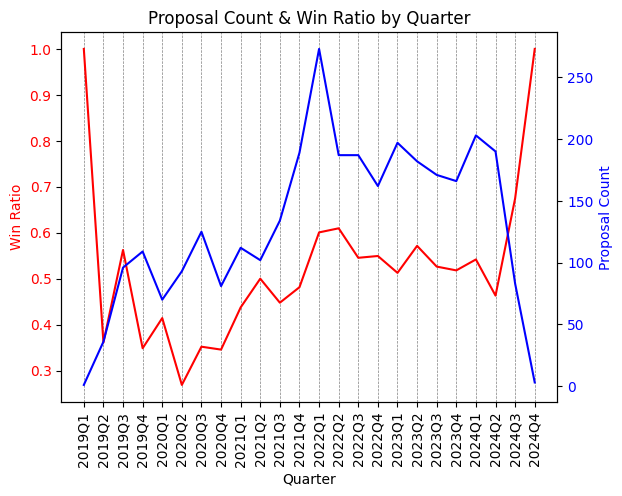

In [ ]:
#Summarize the win/loss ratio by month
prop['quarter'] = prop['issued_date'].dt.to_period('Q')
grouped = prop.groupby('quarter')['outcome'].agg(['mean', 'count'])

#Plot results
fig, ax = plt.subplots()
ax.plot(grouped.index.astype(str), grouped['mean'], color='red')
ax.set_xlabel('Quarter')
ax.set_ylabel('Win Ratio', color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(grouped.index.astype(str), grouped['count'], color='blue')
ax2.set_ylabel('Proposal Count', color = 'blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(True, axis='x', linestyle='--', color='gray', linewidth=0.5)
ax.set_title('Proposal Count & Win Ratio by Quarter')
plt.show()

Proposal count and win rate both increased around 2021 Q4. Will keep this in mind during EDA to see if there is a change in proposal composition around this time. By 2022 Q1 and later the win ratio is relatively stable.

# **region - keep**
This column was found to have a significant impact on outcome. It has been grouped into regions for usability

These values were obtained by taking the first two digits of the client IDs. In the case of condominium corporations, these first two digits represent the region of the registry office that the building is in. We will be able to use these as a region indicator and use them to isolate regions within Ontario such as Toronto

In [ ]:
print(prop['registry_region'].value_counts(dropna=False))

registry_region
TS    441
YR    262
OC    197
MT    196
PC    174
     ... 
Qi      1
Nu      1
Ts      1
I.      1
Ic      1
Name: count, Length: 279, dtype: int64


This column is messy. We will start with some minor cleanup here before we test significance.

In [ ]:
#The true region indicators are the ones that are two capital letters
prop_regions = prop[(prop['registry_region'].str.len() == 2) & (prop['registry_region'].str.isupper())]
print(prop_regions['registry_region'].value_counts(dropna=False))

registry_region
TS    441
YR    262
OC    197
MT    196
PC    174
     ... 
CP      1
PW      1
GO      1
TJ      1
SM      1
Name: count, Length: 109, dtype: int64


At a high level there does seem to be a difference in win rate for toronto (41 percent) vs the rest of Ontario (51 percent)

In [ ]:
#Toronto outcome df
toronto = prop_regions[prop_regions['registry_region'].isin(['MT', 'TS'])]['outcome']

print(toronto.describe())
print('win rate: ', np.mean(toronto))
print(toronto.shape)

count    637.000000
mean       0.420722
std        0.494063
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: outcome, dtype: float64
win rate:  0.4207221350078493
(637,)


In [ ]:
#Non-Toronto outcome df
other = prop_regions[~prop_regions['registry_region'].isin(['MT', 'TS'])]['outcome']

print(other.describe())
print('win rate: ', np.mean(other))
print(other.shape)

count    1590.000000
mean        0.524528
std         0.499555
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: outcome, dtype: float64
win rate:  0.5245283018867924
(1590,)


Hypothesis: There is no difference in win-rate for Toronto vs the rest of Ontario

In [ ]:
sample_a = other
sample_b = toronto

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


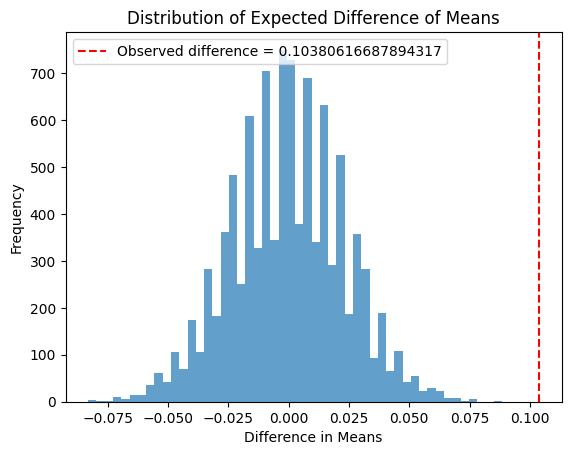

In [ ]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

Region definitely impacts proposla outcome.  We'll want to use it as a feature

**Grouping**

To make this more useable, Registry Offices will be grouped by region

In [ ]:
#Import the mapping table for region & registry offices
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   region = pd.read_excel(io.BytesIO(file_content))

print(region.shape)

Saving 1.2 Region Mapping.xlsx to 1.2 Region Mapping.xlsx
(55, 11)


In [ ]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LRO Acronym                  55 non-null     object 
 1   Land Registry Office         55 non-null     object 
 2   Land Registry Office Number  55 non-null     object 
 3   LRO Street                   55 non-null     object 
 4   Town                         55 non-null     object 
 5   Prov                         55 non-null     object 
 6   Postal                       55 non-null     object 
 7   LRO Tel                      55 non-null     object 
 8   LRO Fax                      55 non-null     object 
 9   CCI Chapter                  55 non-null     object 
 10  Estimated # of Condos        53 non-null     float64
dtypes: float64(1), object(10)
memory usage: 4.9+ KB


In [ ]:
#drop all columns except LRO Acronym and CCI Chapter
region = region[['LRO Acronym', 'CCI Chapter']]

#rename CCI Chapter to region
region.rename(columns={'CCI Chapter': 'region'}, inplace=True)

region.describe()

,LRO Acronym,region
count,55,55
unique,55,10
top,AC,EO
freq,1,17


In [ ]:
#create a region column in prop
print(prop.shape)
prop = pd.merge(prop, region, left_on='registry_region', right_on = 'LRO Acronym', how='left')
print(prop.shape)

(3152, 23)
(3152, 25)


In [ ]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proposal_num     3148 non-null   object        
 1   registry_region  3152 non-null   object        
 2   sow              3151 non-null   object        
 3   rfp              96 non-null     object        
 4   units_orig       2925 non-null   object        
 5   storeys_orig     2847 non-null   object        
 6   townhouse_orig   2766 non-null   object        
 7   parking_orig     2787 non-null   object        
 8   prev_rfs         3142 non-null   object        
 9   reminder         3147 non-null   object        
 10  fee_probable     3152 non-null   float64       
 11  issued_date      3152 non-null   datetime64[ns]
 12  outcome          3152 non-null   int64         
 13  prev_wins        3152 non-null   float64       
 14  townhouse_flag   3152 non-null   float64

In [ ]:
#drop LRO Acronym column
prop.drop(columns=['LRO Acronym'], inplace=True)

In [ ]:
prop['region'].describe()

,region
count,1840
unique,9
top,TOR
freq,769


In [ ]:
prop['region'].value_counts(dropna=False)

,count
region,
NaN,1312
TOR,769
EO,270
YR,262
HUR,243
PC,174
GH,91
LON,13
GR,12


**Nulls**

Some of these nulls are to be expected since the proposal is under the name of the client rather than registry office (H&R for example).

In [ ]:
#display unique registry_office values where region is null
print(prop[prop['region'].isna()]['registry_region'].value_counts())

registry_region
H&    139
CA     61
Co     57
Ci     56
TC     41
     ... 
Xi      1
Qi      1
Nu      1
I.      1
Ic      1
Name: count, Length: 240, dtype: int64


In [ ]:
#Adding some of the older region mappings in
prop.loc[prop['registry_region'] == 'CA', 'region'] = 'EO'

In [ ]:
#% of nulls in the region column
print(prop['region'].isna().mean())

0.3968908629441624


We're not able to interpolate region, so we'll set all remaining region nulls to 'Unknown'

In [ ]:
#where region is null, set value to Unknown
prop.loc[prop['region'].isna(), 'region'] = 'Unknown'

In [ ]:
prop['region'].value_counts(dropna=False)

,count
region,
Unknown,1251
TOR,769
EO,331
YR,262
HUR,243
PC,174
GH,91
LON,13
GR,12


Quick test to confirm the Toronto region impact on outcome is still seen with the new region grouping

In [ ]:
toronto = prop[prop['region'].isin(['TOR'])]['outcome']
other = prop[~prop['region'].isin(['TOR'])]['outcome']

In [ ]:
sample_a = other
sample_b = toronto

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


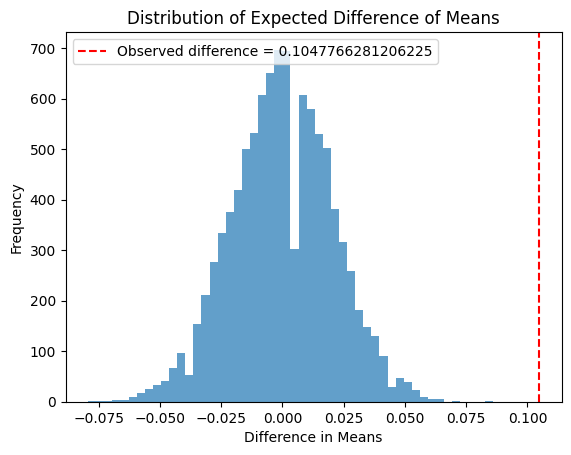

In [ ]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

# **rfp - discard**
There are very few instances of RFP-based proposals (request for proposals) and their behaviour is very different from average proposals. These records will be dropped

This column indicates whether the proposal was submitted in response to a Request for Proposals.

In [ ]:
prop['rfp'].value_counts(dropna=False)

,count
rfp,
NaN,3056
CPR-2024-001,7
SCHI-BCA-2023,2
23030,2
C2024-062,2
...,...
2022-89-OQ,1
TR711-22,1
22242,1


In [ ]:
#Currently the values in the column are rfp IDs where non-rfp proposals are null. We will convert this to a flag where 1 = rfp and 0 = no rfp
prop['rfp'] = np.where(prop['rfp'].str.len() > 0, 1, 0)
print(prop['rfp'].value_counts())

rfp
0    3056
1      96
Name: count, dtype: int64


Only 42 of the proposals are rfps. We may want to exclude these proposals, or not use the flag as a feature. Lets explore:

In [ ]:
no_rfp = prop[prop['rfp'] == 0]
rfp = prop[prop['rfp'] == 1]

pd.set_option('display.float_format', '{:.6f}'.format)

print('no rfp:', no_rfp[['fee_probable', 'outcome']].describe())
print('rfp:', rfp[['fee_probable', 'outcome']].describe())

no rfp:        fee_probable     outcome
count   3056.000000 3056.000000
mean   11371.388743    0.508835
std    37254.658621    0.500004
min        0.000000    0.000000
25%     2495.000000    0.000000
50%     3600.000000    1.000000
75%     6495.000000    1.000000
max   651000.000000    1.000000
rfp:         fee_probable   outcome
count      96.000000 96.000000
mean   148450.264792  0.364583
std    373224.771049  0.483840
min         0.000000  0.000000
25%     20075.000000  0.000000
50%     44169.500000  0.000000
75%    108457.500000  1.000000
max   2858397.000000  1.000000


The rfp proposals are generally much larger than a regular proposal with an average probable fee of 147k vs 11k for non-rfp proposals.


Even when we break down the differences by project type, the rfp proposals are generally worth quite a bit more than the non-rfp projects. They also have a lower success rate.

In [ ]:
rfp = prop[prop['rfp'] == 1]
no_rfp = prop[prop['rfp'] == 0]

rfp_grouped = rfp.groupby(['project_type'])['fee_probable'].agg(['mean', 'median', 'count'])
print('rfp:', rfp_grouped)

no_rfp_grouped = no_rfp.groupby(['project_type'])['fee_probable'].agg(['mean', 'median', 'count'])
print('rfp:', no_rfp_grouped)

rfp:                       mean       median  count
project_type                                  
AA            68300.000000 68300.000000      1
Assessment   176359.674035 50500.000000     57
Consult       39970.000000 35700.000000     10
Envelope     118868.652174 44839.000000     23
RFS            4995.000000  4995.000000      1
rfp:                      mean      median  count
project_type                                
AA           25432.777778 8010.000000      9
Assessment   24200.495868 6250.000000    726
Consult      12728.293706 3995.000000    286
Envelope     17523.955307 5000.000000    358
Mechanical    6865.155172 1990.000000    116
RFS           3911.869215 3095.000000   1491


In [ ]:
print('rfp:', rfp.groupby('project_type')['outcome'].agg(['mean', 'count']))
print('no rfp:', no_rfp.groupby('project_type')['outcome'].agg(['mean', 'count']))

rfp:                  mean  count
project_type                
AA           0.000000      1
Assessment   0.438596     57
Consult      0.500000     10
Envelope     0.130435     23
RFS          1.000000      1
no rfp:                  mean  count
project_type                
AA           0.444444      9
Assessment   0.564738    726
Consult      0.520979    286
Envelope     0.553073    358
Mechanical   0.732759    116
RFS          0.452716   1491


I recommend removing the rfp-based proposals from the dataset. They are a very small subset with less than 50 instances, and they are abnormal in terms of size and outcome

In [ ]:
#keep only the rows where the rfp column is 0
prop = prop[prop['rfp'] == 0]

In [ ]:
print(prop.shape)

(3056, 24)


# **project_type - keep**
Proposal outcome varies significantly by project_type so this feature will be retained for modeling

A categorization of the type of project the proposal pertains to. The type of information available in this data is also dependent on project_type

At a very high level, it appears the likelihood of a proposal being successful varies by project type

In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1491
Assessment,726
Envelope,358
Consult,286
Mechanical,116
NaN,70
AA,9


In [ ]:
prop.groupby('project_type')['outcome'].agg(['mean', 'count'])

,mean,count
project_type,,
AA,0.444444,9
Assessment,0.564738,726
Consult,0.520979,286
Envelope,0.553073,358
Mechanical,0.732759,116
RFS,0.452716,1491


Hypthesis: There is no difference in outcome between Assessment and RFS projects

In [ ]:
sample_a = prop[prop['project_type'] == 'Assessment']['outcome']
sample_b = prop[prop['project_type'] == 'RFS']['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


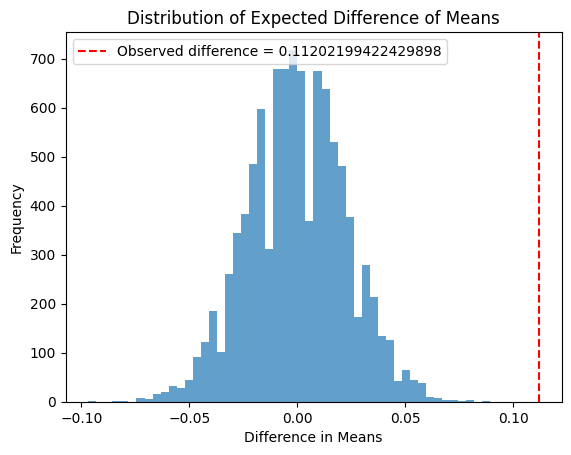

In [ ]:
import matplotlib.pyplot as plt
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

project_type almost certainly has an impact on proposal outcome. We will carry this feature over into our analysis

**Nulls**

There are a few nulls in this column. The sow column may help to fill this in so we'll revisit in that section

In [ ]:
prop['project_type'].isna().sum()

70

# **fee_probable - first pass - inconclusive**
We were unable to describe this variable with the current feature set. We will have to return to this column

This column contains the expected project value that would be received if the project is won. This reflects the fee proposed in the proposal, and does not reflect any adjustments made after the final proposal is submitted.

There is a huge amount of variation in this variable. The IQR is tight, ranging from 2500 to 7000, but the standard deviation is a massive 78,000. There are some extremely large values skewing this data

In [ ]:
prop['fee_probable'].describe()

,fee_probable
count,3056.000000
mean,11371.388743
std,37254.658621
min,0.000000
25%,2495.000000
50%,3600.000000
75%,6495.000000
max,651000.000000


**Removing 0s**

In [ ]:
prop['fee_probable'].replace(0, np.nan, inplace=True)

<ipython-input-48-f0502e293278>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prop['fee_probable'].replace(0, np.nan, inplace=True)


**Nulls**

In [ ]:
prop['fee_probable'].isna().sum()

3

In [ ]:
prop.shape

(3056, 24)

In [ ]:
#Drop rows that deo not have a fee_probable
prop.dropna(subset=['fee_probable'], inplace=True)

In [ ]:
prop.shape

(3053, 24)

**Distribution**

The data is similar to an exponential distribution, but is more extreme in its left skew and the length of the tail to the right.

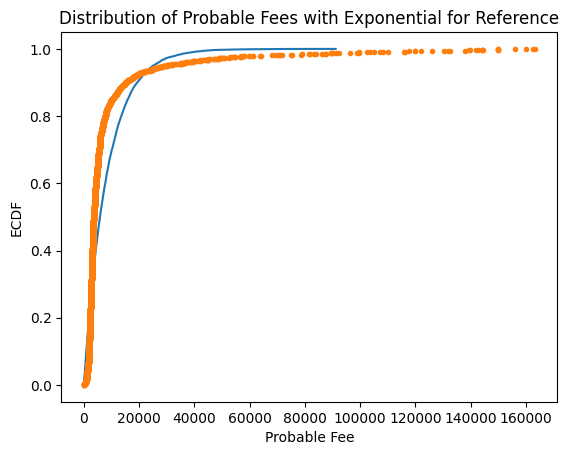

In [ ]:
#Exponential Distribution Comparison
# The top results are extreme, so they will be removed before running the distribution
percentile_99 = np.nanpercentile(prop['fee_probable'], 99)
filtered_prop = prop[prop['fee_probable'] <= percentile_99]
filtered_prop = filtered_prop.dropna(subset=['fee_probable'])

rng = np.random.default_rng()

mean = np.mean(filtered_prop['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Probable Fees with Exponential for Reference')
plt.show()

Log Transformation

Converting the fee_probable with a log transformation does not work well because the data is so heavily skewed. It helps to reign in the larger values, but comresses the already dense majority

In [ ]:
log_fee_probable = np.log1p(prop['fee_probable'])
log_fee_probable.dropna(inplace=True)

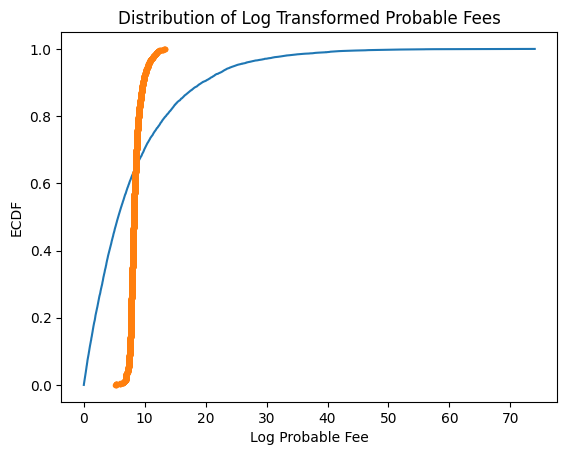

In [ ]:
mean = np.mean(log_fee_probable)
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(log_fee_probable)
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Log Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Log Transformed Probable Fees')
plt.show()

Square Root Transformation

This does a better job of converting the data than log, but it is still extremely clustered to the left

In [ ]:
sqrt_fee_probable = np.sqrt(prop['fee_probable'])
sqrt_fee_probable.dropna(inplace=True)

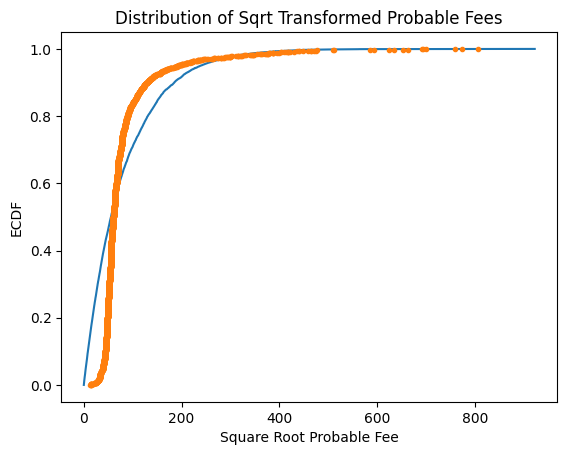

In [ ]:
mean = np.mean(sqrt_fee_probable)
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(sqrt_fee_probable)
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Square Root Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Sqrt Transformed Probable Fees')
plt.show()

Variation in fee by project type

The different project types likely have a different spread in terms of fee_probable. Taking this into account might help make sense of the fee distribution

There are definitely differences by project type. RFS proposals are much more cententrated at lower values, while Assessments are much more spread out. That said, all project types have an extremely condensed IQR and large std. There may not be enough variation in this value to be useful

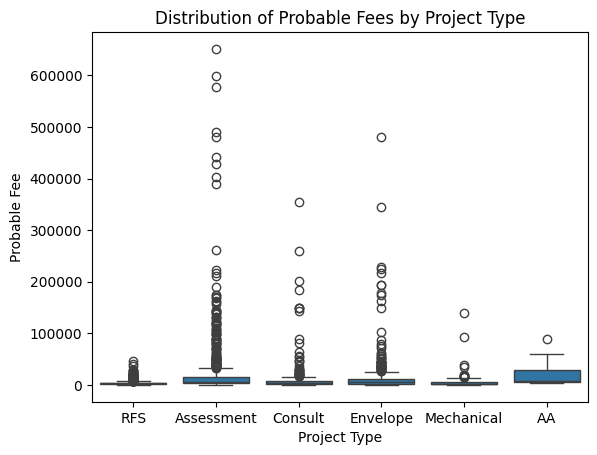

In [ ]:
_ = sns.boxplot(x='project_type',y='fee_probable', data = prop)
_ = plt.xlabel('Project Type')
_ = plt.ylabel('Probable Fee')
_ = plt.title('Distribution of Probable Fees by Project Type')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
#IQR of fee_probable by project_type
rfs = prop[prop['project_type'] == 'RFS']
assessment = prop[prop['project_type'] == 'Assessment']
consult = prop[prop['project_type'] == 'Consult']
envelope = prop[prop['project_type'] == 'Envelope']
mechanical = prop[prop['project_type'] == 'Mechanical']
AA = prop[prop['project_type'] == 'AA']

print('rfs:', rfs['fee_probable'].describe())
print('assessment:', assessment['fee_probable'].describe())
print('consult:', consult['fee_probable'].describe())
print('envelope:', envelope['fee_probable'].describe())
print('mechanical:', mechanical['fee_probable'].describe())

rfs: count    1491.000000
mean     3911.869215
std      3249.471304
min       932.000000
25%      2395.000000
50%      3095.000000
75%      4195.000000
max     47285.000000
Name: fee_probable, dtype: float64
assessment: count      725.000000
mean     24233.875862
std      63383.403613
min        175.000000
25%       3495.000000
50%       6250.000000
75%      14995.000000
max     651000.000000
Name: fee_probable, dtype: float64
consult: count      285.000000
mean     12772.954386
std      35591.455667
min        195.000000
25%       1995.000000
50%       3995.000000
75%       7985.000000
max     353720.000000
Name: fee_probable, dtype: float64
envelope: count      357.000000
mean     17573.042017
std      44089.947161
min        195.000000
25%       2695.000000
50%       5000.000000
75%      12250.000000
max     480000.000000
Name: fee_probable, dtype: float64
mechanical: count      116.000000
mean      6865.155172
std      16192.514379
min        195.000000
25%       1100.000000
50%   

**Distribution of fee_probable for RFS projects**

Noen of these sufficiently describe our data. Even within the RFS project type the left skew is too heavy

Exponential Distribution vs RFS fee_probable

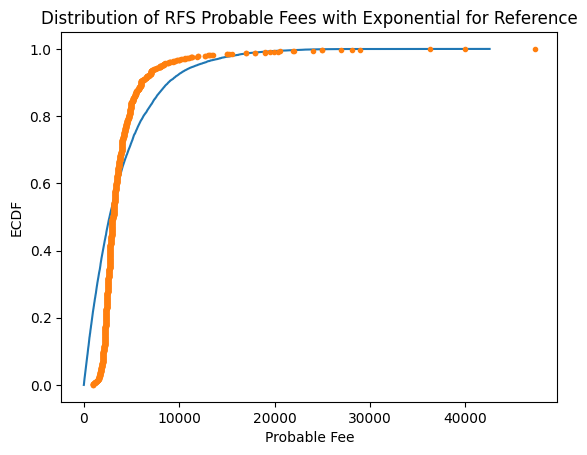

In [ ]:
mean = np.mean(rfs['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees with Exponential for Reference')
plt.show()

Normal Distribution

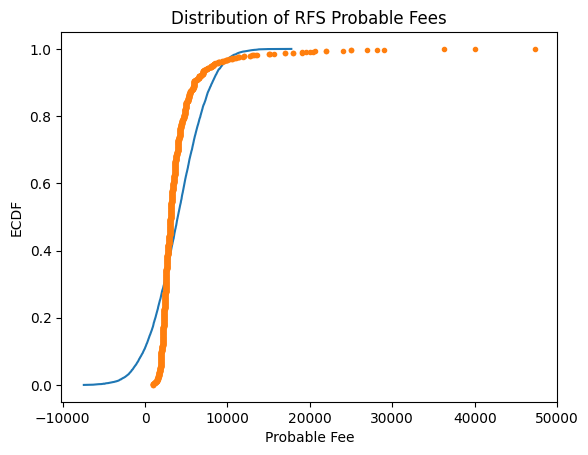

In [ ]:
#Normal Distribution
filtered_prop = prop[prop['project_type'] == 'RFS']
filtered_prop = filtered_prop.dropna(subset=['fee_probable'])

rng = np.random.default_rng()

mean = np.mean(filtered_prop['fee_probable'])
std = np.std(filtered_prop['fee_probable'])
samples = rng.normal(mean, std, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees')
plt.show()

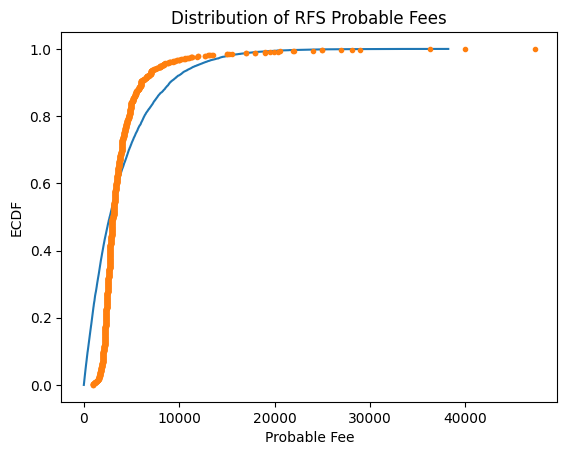

In [ ]:
#Exponential (no transformation)
mean = np.mean(filtered_prop['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees')
plt.show()

**Testing revised grouping**

Since the project type starts to explain the distribution but still has too much clustering to be described, our project groupings are probably not specific enough.

In [ ]:
#print unique values in sow column that contain the text 'rfs' in them
prop['sow'].unique()

array(['Update RFS', 'Class 2 RFS', 'Class 3 RFS', 'Class 1 RFS',
       'PA1, C1, PA2', 'C2 RFS with C3 Fee', 'PA & Class 1 RFS',
       'BCA & RFS', 'PPA', 'Consult', 'PA Year 1', 'BCA', 'PA Follow-Up',
       'Roofing', 'Garage ', 'Stairs', 'Envelope', 'Renovation',
       'Balcony', 'Pavement', 'PCA', 'PA Year 7', 'Windows', 'Mechanical',
       'PA Year 2', 'PCA/ESA', 'PCA & ESA', 'Doors', 'Sealants',
       'Landscaping ', 'Structural', 'Accessibility Audit', 'Bulletin 18',
       nan, 'Energy Audits', 'Electrical'], dtype=object)

Let's start with the Class 3 RFS

In [ ]:
rfs_c3 = rfs[rfs['sow'].isin([ 'Class 3 RFS', 'Update RFS'])]

#drop null rfs_c3 probable fees
rfs_c3 = rfs_c3.dropna(subset=['fee_probable'])

print(rfs_c3.shape)
rfs_c3.describe()

(473, 24)


,rfp,fee_probable,issued_date,outcome,prev_wins,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age
count,473.000000,473.000000,473,473.000000,473.000000,473.000000,254.000000,473.000000,75.000000,38.000000,328.000000,436.000000
mean,0.000000,2900.799154,2022-01-09 02:32:13.192388864,0.634249,0.443975,0.245243,12.874016,0.158562,27.946667,46.710526,110.387195,23.788991
min,0.000000,950.000000,2019-03-22 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,6.000000,3.000000,0.000000
25%,0.000000,2195.000000,2020-08-28 00:00:00,0.000000,0.000000,0.000000,3.000000,0.000000,8.000000,22.250000,25.500000,11.000000
50%,0.000000,2495.000000,2022-01-25 00:00:00,1.000000,0.000000,0.000000,4.000000,0.000000,19.000000,45.000000,54.000000,19.000000
75%,0.000000,3395.000000,2023-05-08 00:00:00,1.000000,1.000000,0.000000,15.000000,0.000000,35.500000,53.750000,147.250000,35.000000
max,0.000000,8395.000000,2024-10-03 00:00:00,1.000000,5.000000,1.000000,637.000000,1.000000,178.000000,150.000000,616.000000,64.000000
std,0.000000,1158.705272,NaN,0.482150,0.655429,0.430687,42.160055,0.365654,32.254433,32.872323,126.088482,15.594030


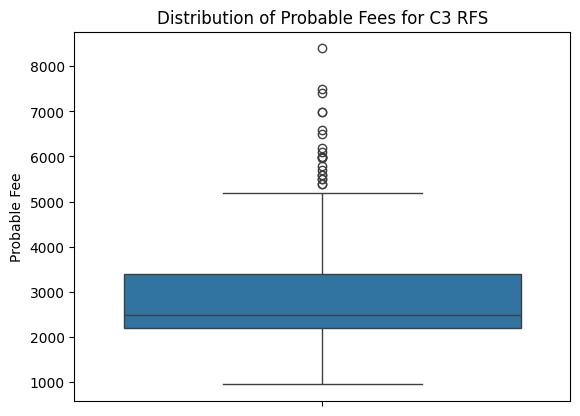

In [ ]:
_ = sns.boxplot(y='fee_probable', data = rfs_c3)
_ = plt.ylabel('Probable Fee')
_ = plt.title('Distribution of Probable Fees for C3 RFS')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

There is less skew of fee_probable within the individual project category. Given this, we will revisit the project_type groupings

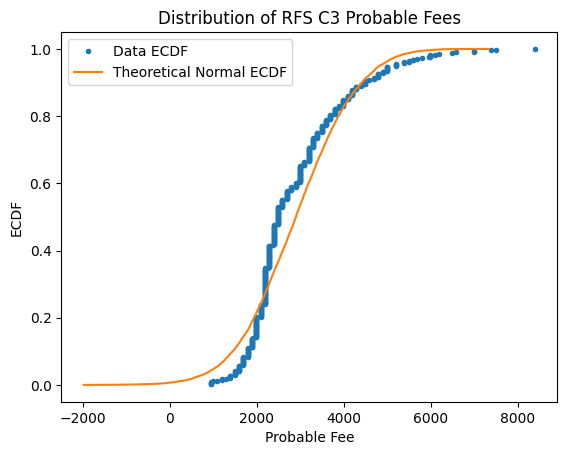

In [ ]:
mean = np.mean(rfs_c3['fee_probable'])
std_dev = np.std(rfs_c3['fee_probable'])
samples = rng.normal(mean, std_dev, size=10000)

ecdf_data = ECDF(rfs_c3['fee_probable'])
ecdf_samples = ECDF(samples)

_ = plt.plot(ecdf_data.x, ecdf_data.y, label='Data ECDF', marker = '.', linestyle = 'none')
_ = plt.plot(ecdf_samples.x, ecdf_samples.y, label='Theoretical Normal ECDF')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS C3 Probable Fees')
_ = plt.legend()
_ = plt.show()

# **sow / project_type - keep**
There is variation among the project types that can be seen better with the ungrouped sow categories. We will keep this feature for further exploration

This is the detailed (ungrouped) project_type classification.

In [ ]:
prop['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,844
Update RFS,457
Consult,285
PCA,268
BCA,258
Roofing,153
Mechanical,116
Envelope,101
Garage,98


There's a lot here so we're going to go by project_type to see how the different sows in each behave

We will deal with outliers at the end of this section once we have finished recategorizing

**RFS**

In [ ]:
#value counts of sow from the prop df where project_type = rfs
print(prop['sow'][prop['project_type'] == 'RFS'].value_counts(dropna=False))
print(rfs['sow'].value_counts(dropna=False))

sow
Class 2 RFS         844
Update RFS          457
PA & Class 1 RFS     88
Class 1 RFS          53
BCA & RFS            33
Class 3 RFS          16
Name: count, dtype: int64
sow
Class 2 RFS         844
Update RFS          457
PA & Class 1 RFS     88
Class 1 RFS          53
BCA & RFS            33
Class 3 RFS          16
Name: count, dtype: int64


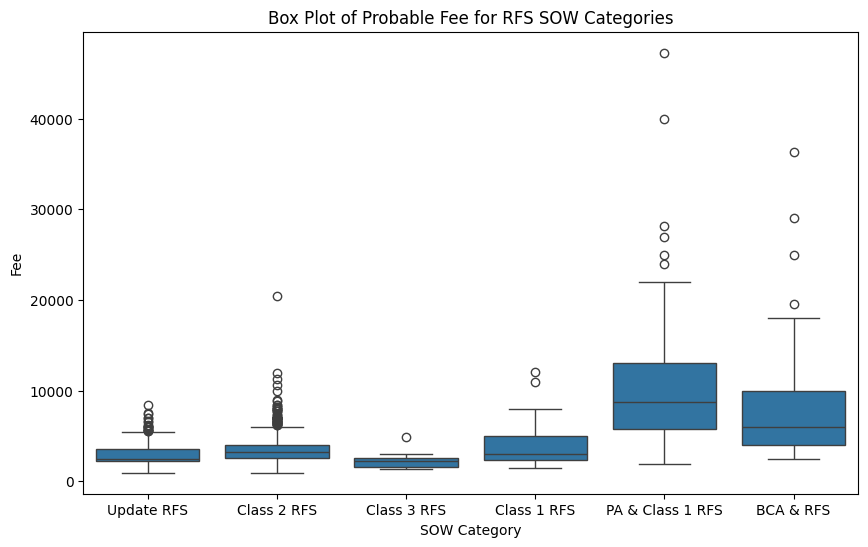

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=rfs)

plt.title("Box Plot of Probable Fee for RFS SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

Based on this, we'll remove 'PA & Class 1 RFS' and 'BCA & RFS' from the RFS project_type, and we'll keep the others grouped

In [ ]:
#where sow = PA & Class 1 RFS, change project_type to PA & Class 1 RFS
prop.loc[prop['sow'] == 'PA & Class 1 RFS', 'project_type'] = 'PA & Class 1 RFS'
prop.loc[prop['sow'] == 'BCA & RFS', 'project_type'] = 'BCA & RFS'

#remove 'PA & Class 1 RFS' and 'BCA & RFS' sow types from rfs
rfs = rfs[~rfs['sow'].isin(['PA & Class 1 RFS', 'BCA & RFS'])]

In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
Assessment,725
Envelope,357
Consult,285
Mechanical,116
PA & Class 1 RFS,88
NaN,70
BCA & RFS,33
AA,9


**Assessment**

In [ ]:
#Summarize count of sow types within the project_type = assessment
print(prop['sow'][prop['project_type'] == 'Assessment'].value_counts(dropna=False))
print(assessment['sow'].value_counts(dropna=False))

sow
PCA             268
BCA             258
Garage           98
PPA              52
PA1, C1, PA2     27
PA Follow-Up     12
PA Year 7         6
PA Year 1         4
Name: count, dtype: int64
sow
PCA             268
BCA             258
Garage           98
PPA              52
PA1, C1, PA2     27
PA Follow-Up     12
PA Year 7         6
PA Year 1         4
Name: count, dtype: int64


These categories are all quite different. We'll remove the Assessment category from the projects altogether

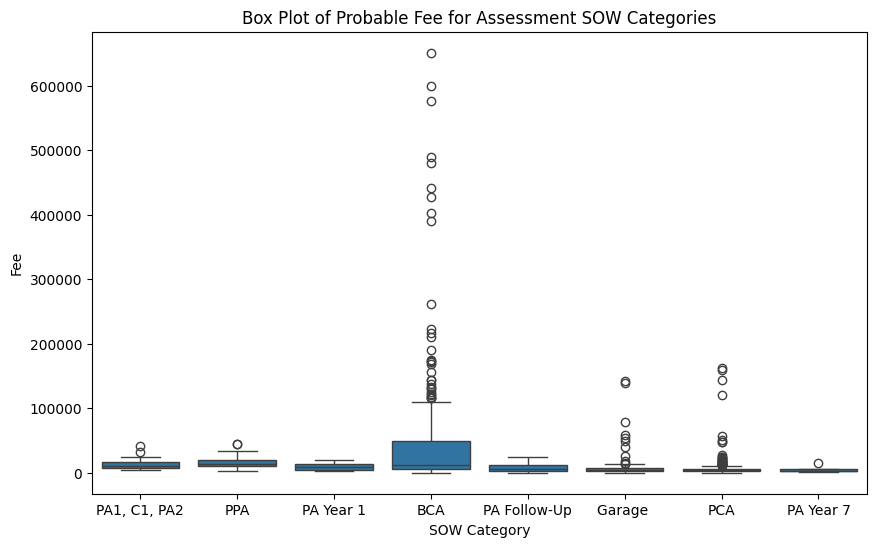

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [ ]:
#Remove trailing spaces causing duplicate sow categories
assessment['sow'] = assessment['sow'].str.strip()
prop['sow'] = prop['sow'].str.strip()

<ipython-input-74-4d71fb6991ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessment['sow'] = assessment['sow'].str.strip()


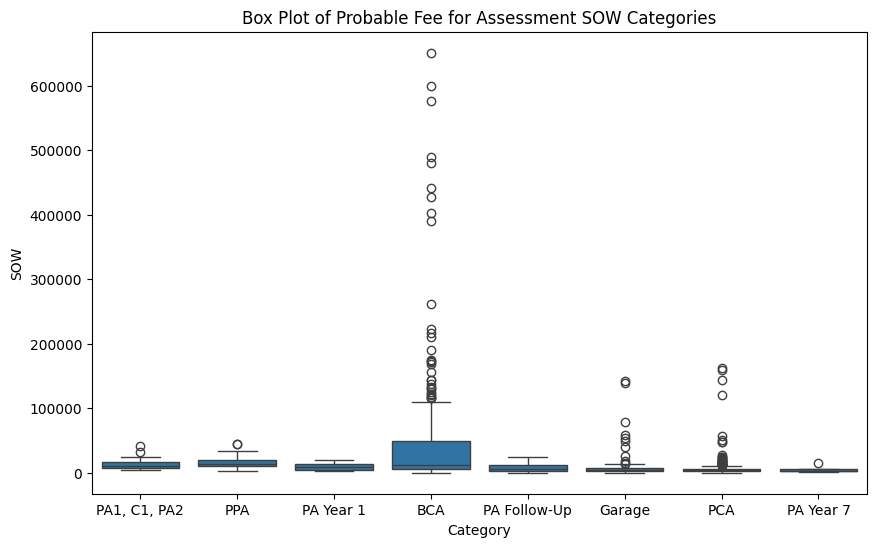

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("Category")
plt.ylabel("SOW")

plt.show()

BCA and Garage have the quantity and varaince to be their own categories

In [ ]:
#Change BCA and Garage project_types in prop
prop.loc[prop['sow'] == 'BCA', 'project_type'] = 'BCA'
prop.loc[prop['sow'] == 'Garage', 'project_type'] = 'Garage'

#remove 'BCA' and 'Garage' sow types from assessments
assessment = assessment[~assessment['sow'].isin(['BCA', 'Garage'])]

assessment['sow'].value_counts(dropna=False)

,count
sow,
PCA,268
PPA,52
"PA1, C1, PA2",27
PA Follow-Up,12
PA Year 7,6
PA Year 1,4


In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
Assessment,369
Envelope,357
Consult,285
BCA,258
Mechanical,116
Garage,98
PA & Class 1 RFS,88
NaN,70


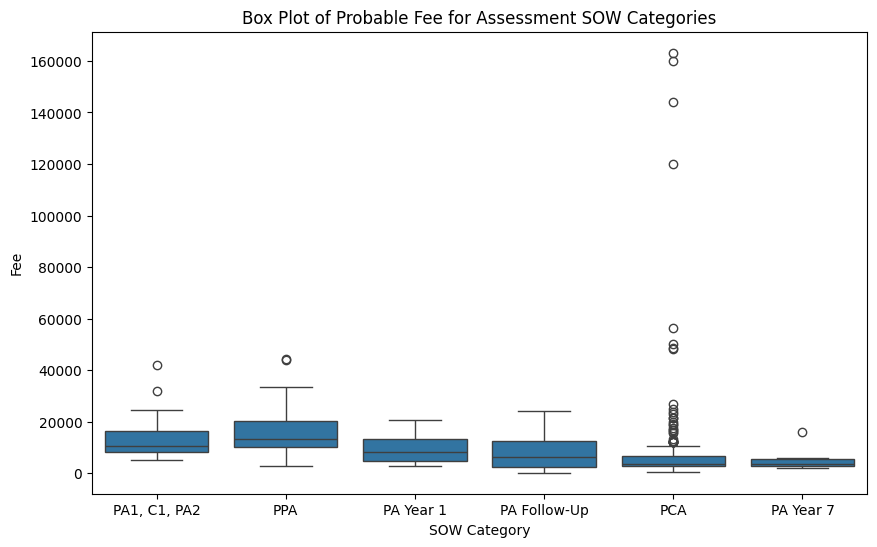

In [ ]:
#Plot remaining Assessment sow types
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

We'll group PA Year 1, PA Follow-Up and PA Year 7. The other categories will be on their own

In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
Assessment,369
Envelope,357
Consult,285
BCA,258
Mechanical,116
Garage,98
PA & Class 1 RFS,88
NaN,70


In [ ]:
#Create a new PA group
prop.loc[prop['sow'] == 'PA Year 1', 'project_type'] = 'PA'
prop.loc[prop['sow'] == 'PA Follow-Up', 'project_type'] = 'PA'
prop.loc[prop['sow'] == 'PA Year 7', 'project_type'] = 'PA'

In [ ]:
#Set PCA to its own category since it has almost 100 proposals in it
prop.loc[prop['sow'] == 'PCA', 'project_type'] = 'PCA'

In [ ]:
#Set the unique, low-count others to Other
prop.loc[prop['sow'].isin(['PA1, C1, PA2', 'PPA']), 'project_type'] = 'Other'

In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
Envelope,357
Consult,285
PCA,268
BCA,258
Mechanical,116
Garage,98
PA & Class 1 RFS,88
Other,79


**Envelope**

In [ ]:
print(prop['sow'][prop['project_type'] == 'Envelope'].value_counts(dropna=False))
print(envelope['sow'].value_counts(dropna=False))

sow
Roofing       153
Envelope      101
Balcony        46
Structural     27
Windows        18
Sealants        8
Stairs          2
Doors           2
Name: count, dtype: int64
sow
Roofing       153
Envelope      101
Balcony        46
Structural     27
Windows        18
Sealants        8
Stairs          2
Doors           2
Name: count, dtype: int64


We can keep most of these grouped as 'Envelope'. The categories that do vary are generally the ones with very small proposal count in them

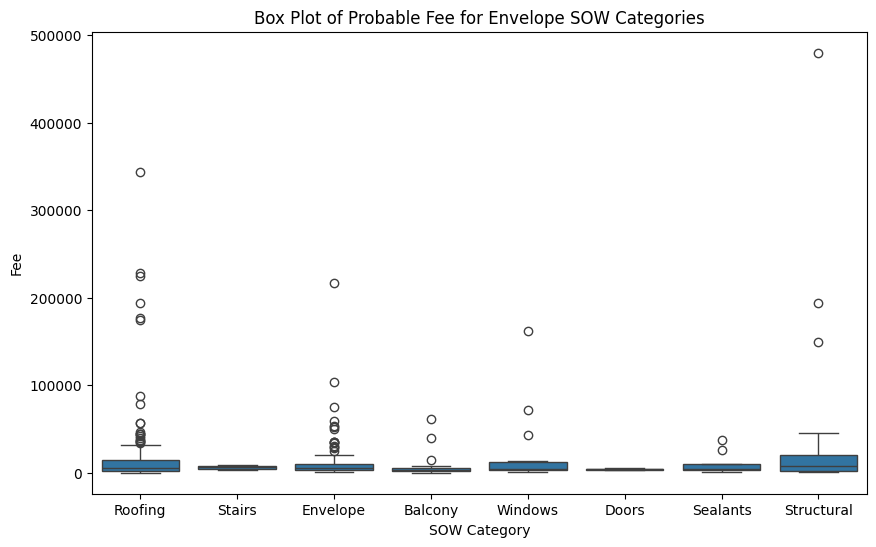

In [ ]:
#Plot Envelope project types
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

Roofing is a large category with 111 proposals, so we'll break that out into its own project_type

In [ ]:
prop.loc[prop['sow'] == 'Roofing', 'project_type'] = 'Roofing'

**Consult**

There are no sub-categories here to clean up, and there are enough records at 190 to justify aunique category. There are quite a few outliers for us to deal with though (will get to this at the end of the section)

In [ ]:
print(prop['sow'][prop['project_type'] == 'Consult'].value_counts(dropna=False))
print(consult['sow'].value_counts(dropna=False))

sow
Consult    285
Name: count, dtype: int64
sow
Consult    285
Name: count, dtype: int64


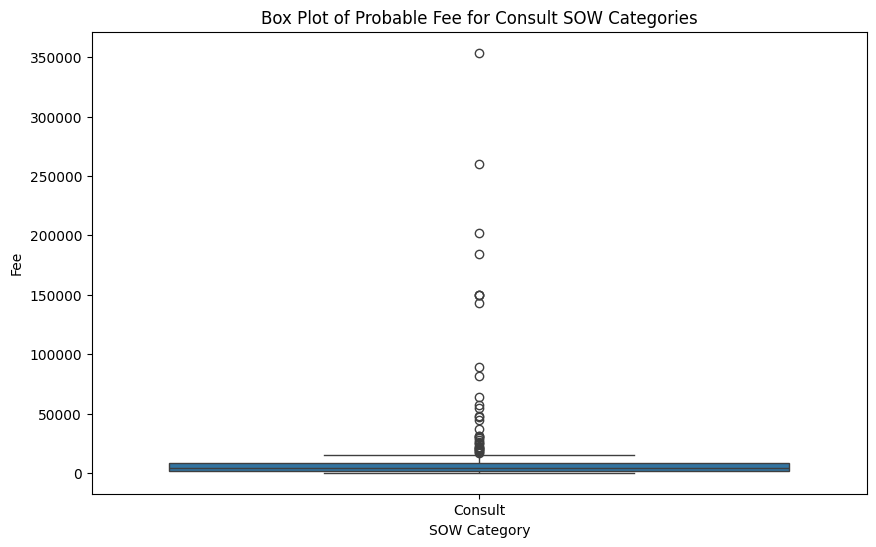

In [ ]:
#Display Consult values
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=consult)

plt.title("Box Plot of Probable Fee for Consult SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [ ]:
consult['fee_probable'].describe()

,fee_probable
count,285.000000
mean,12772.954386
std,35591.455667
min,195.000000
25%,1995.000000
50%,3995.000000
75%,7985.000000
max,353720.000000


**Mechanical & AA**

There are very few records in these project_types (47 and 1 respectively) and no sub-categories

In [ ]:
print(prop['sow'][prop['project_type'] == 'Mechanical'].value_counts(dropna=False))
print(mechanical['sow'].value_counts(dropna=False))

print(prop['sow'][prop['project_type'] == 'AA'].value_counts(dropna=False))
print(AA['sow'].value_counts(dropna=False))

sow
Mechanical    116
Name: count, dtype: int64
sow
Mechanical    116
Name: count, dtype: int64
sow
Accessibility Audit    9
Name: count, dtype: int64
sow
Accessibility Audit    9
Name: count, dtype: int64


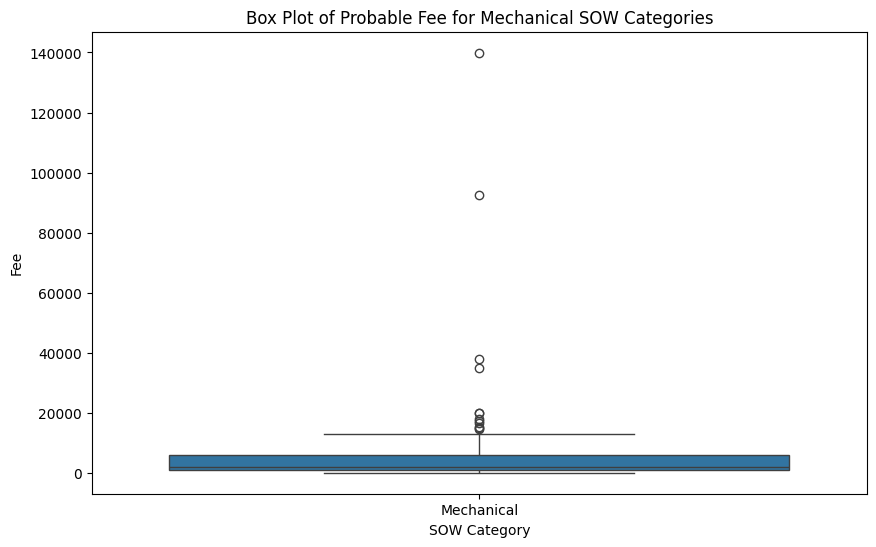

In [ ]:
#Display Mechanical values
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=mechanical)

plt.title("Box Plot of Probable Fee for Mechanical SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [ ]:
mechanical['fee_probable'].describe()

,fee_probable
count,116.000000
mean,6865.155172
std,16192.514379
min,195.000000
25%,1100.000000
50%,1990.000000
75%,6200.000000
max,139900.000000


Since there is only 1 AA proposal we will set it to 'Other'

In [ ]:
prop.loc[prop['sow'] == 'Accessibility Audit', 'project_type'] = 'Other'

**Re-Classifed project_type check**

Check the results of our reclassification work



In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
Consult,285
PCA,268
BCA,258
Envelope,204
Roofing,153
Mechanical,116
Garage,98
Other,88


There are some low-count categories that we shoudl look into reclassifying: PA and BCA & RFS

In [ ]:
#move PA to Other
prop.loc[prop['project_type'] == 'PA', 'project_type'] = 'Other'

In [ ]:
#Should 'BCA & RFS' be grouped with BCA or Other? This was with RFS originally
bca_type = prop[prop['project_type'].isin(['BCA & RFS', 'BCA'])]
bca_type['project_type'].value_counts()

,count
project_type,
BCA,258
BCA & RFS,33


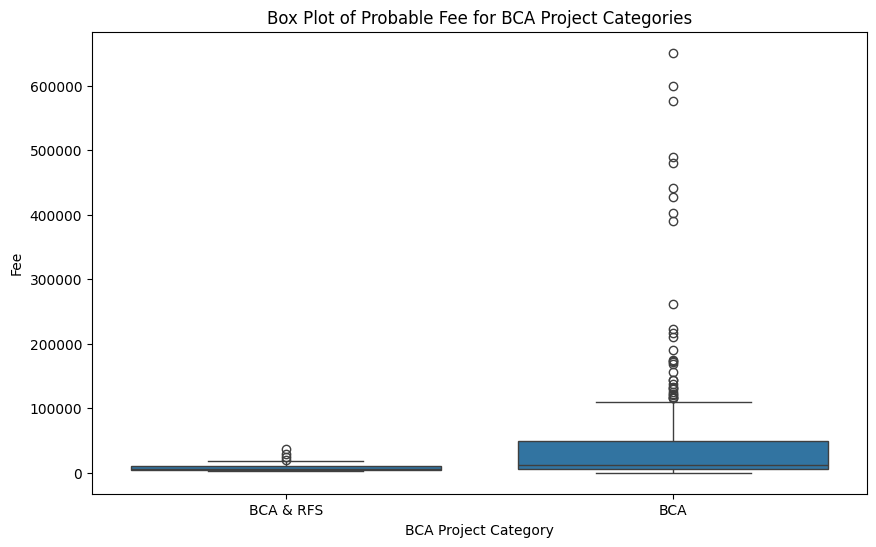

In [ ]:
#BCA vs BCA & RFS
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=bca_type)

plt.title("Box Plot of Probable Fee for BCA Project Categories")
plt.xlabel("BCA Project Category")
plt.ylabel("Fee")

plt.show()

There is a lot of overlap here, so we'll merge the two categories

In [ ]:
prop.loc[prop['project_type'] == 'BCA & RFS', 'project_type'] = 'BCA'

In [ ]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1370
BCA,291
Consult,285
PCA,268
Envelope,204
Roofing,153
Mechanical,116
Other,110
Garage,98


**Nulls**

The nulls mostly look to be very rarely used SOW codes that had no project_type mapping. These can all be assigned to Other

In [ ]:
prop['sow'][prop['project_type'].isnull()].value_counts(dropna=False)

,count
sow,
Pavement,22
Renovation,15
Landscaping,14
Bulletin 18,7
C2 RFS with C3 Fee,5
Electrical,2
PA Year 2,1
PCA/ESA,1
PCA & ESA,1


In [ ]:
prop.loc[prop['project_type'].isnull(), 'project_type'] = 'Other'

In [ ]:
#Rows where sow is null
prop[prop['sow'].isnull()]

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region
2058,PCC-233976-00,Sc,NaN,0,-,-,-,-,No,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,111.000000,Other,2023Q1,Unknown


In [ ]:
#Remove these sow null rows from the data since they are null almost completely across the board
prop = prop.dropna(subset=['sow'])

**Summary of SOW Groupings**

In [ ]:
prop.groupby('project_type')['sow'].unique().reset_index()

,project_type,sow
0,BCA,"[BCA & RFS, BCA]"
1,Consult,[Consult]
2,Envelope,"[Stairs, Envelope, Balcony, Windows, Doors, Se..."
3,Garage,[Garage]
4,Mechanical,[Mechanical]
5,Other,"[PA1, C1, PA2, C2 RFS with C3 Fee, PPA, PA Yea..."
6,PA & Class 1 RFS,[PA & Class 1 RFS]
7,PCA,[PCA]
8,RFS,"[Update RFS, Class 2 RFS, Class 3 RFS, Class 1..."
9,Roofing,[Roofing]


In [ ]:
prop['project_type'].value_counts()

,count
project_type,
RFS,1370
BCA,291
Consult,285
PCA,268
Envelope,204
Other,179
Roofing,153
Mechanical,116
Garage,98


**Outliers**

We're going to set a fee_probable ceiling at the 90th percentile for each category

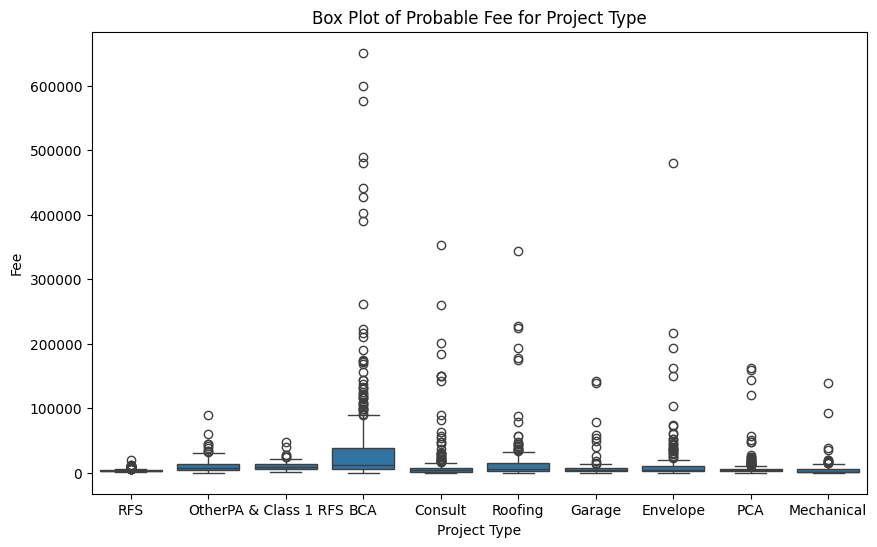

In [ ]:
#boxplot of project_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='project_type', y='fee_probable', data=prop)

plt.title("Box Plot of Probable Fee for Project Type")
plt.xlabel("Project Type")
plt.ylabel("Fee")

plt.show()

In [ ]:
#calculate the 90th percentile for each project_type category
fee_percentiles = prop.groupby('project_type')['fee_probable'].quantile(0.9)
fee_percentiles

,fee_probable
project_type,
BCA,116400.000000
Consult,19980.000000
Envelope,35000.000000
Garage,14283.000000
Mechanical,13895.000000
Other,24514.000000
PA & Class 1 RFS,20170.000000
PCA,12000.000000
RFS,5195.000000


In [ ]:
#FEE_PROBABLE WILL BE BUCKETED SO ADDING A CEILING IS NOT NEEDED
#for each project_type, set any fee_probable above the project's fee_percentile to = the fee_percentile
#for project_type, fee_percentile in fee_percentiles.items():
    #prop.loc[(prop['project_type'] == project_type) & (prop['fee_probable'] > fee_percentile), 'fee_probable'] = fee_percentile

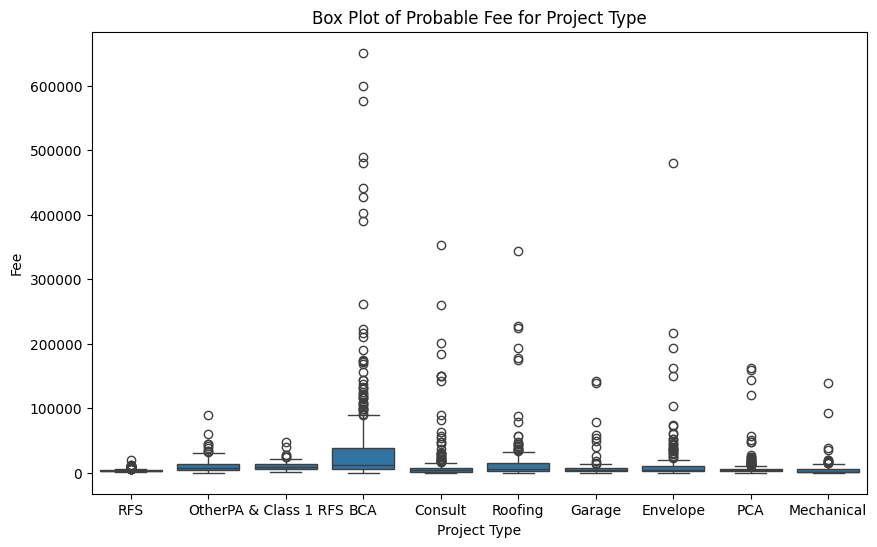

In [ ]:
#boxplot of project_types
plt.figure(figsize=(10, 6))
sns.boxplot(x='project_type', y='fee_probable', data=prop)

plt.title("Box Plot of Probable Fee for Project Type")
plt.xlabel("Project Type")
plt.ylabel("Fee")

plt.show()

# **fee_probable - second pass - keep with adjustments**
We're still unable to explain the distribution for the fee_probable column with the information that we have. This will have to be bucketed for use in the analysis

Revisitng fee_probable distribution now that we've revamped our project_type classification

In [ ]:
prop['project_type'].value_counts()

,count
project_type,
RFS,1370
BCA,291
Consult,285
PCA,268
Envelope,204
Other,179
Roofing,153
Mechanical,116
Garage,98


**RFS**

RFS is similar to a normal distribution, but still not a complete fit

In [ ]:
rfs = prop[prop['project_type']=='RFS']

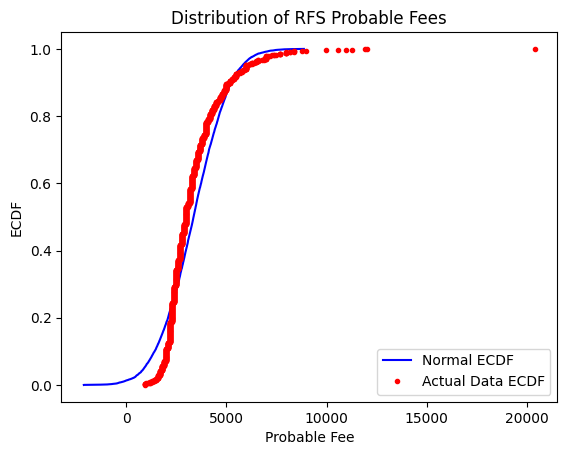

In [ ]:
#Normal Distribution
fee_probable = rfs['fee_probable']
std = np.std(fee_probable)
mean = np.mean(fee_probable)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

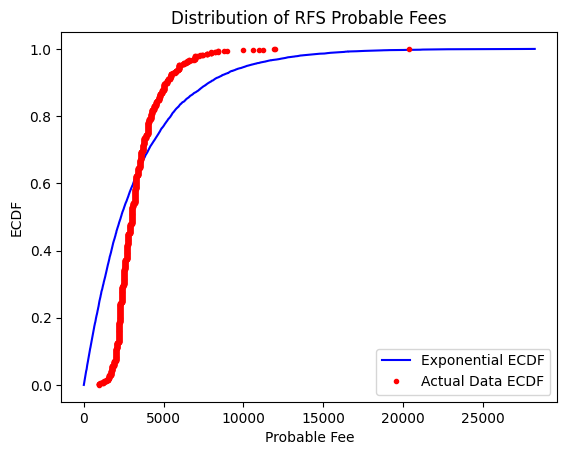

In [ ]:
#Exponential Distribution
fee_probable = rfs['fee_probable']
mean = np.mean(fee_probable)

samples = np.random.exponential(mean, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Exponential ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

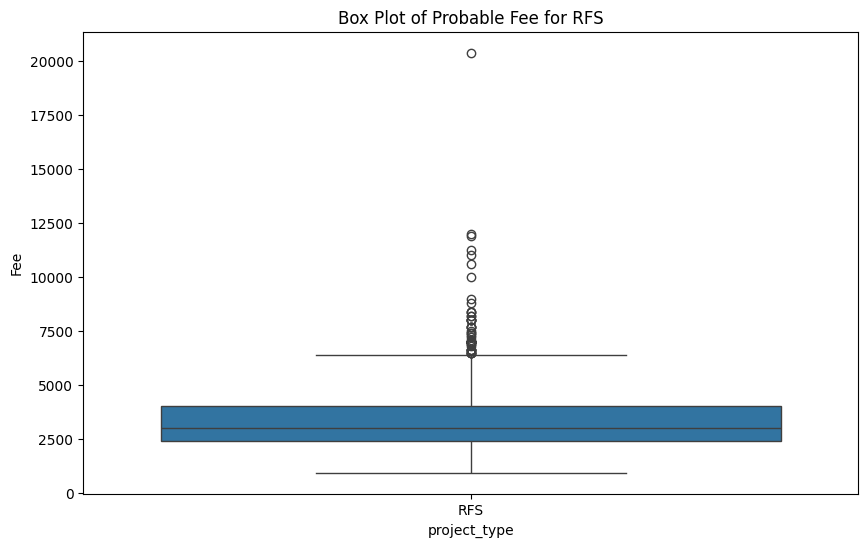

6395.0


In [ ]:
#Boxplot of RFS
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='project_type', y='fee_probable', data=rfs)

plt.title("Box Plot of Probable Fee for RFS")
plt.ylabel("Fee")

plt.show()

iqr = fee_probable.quantile(0.75) - fee_probable.quantile(0.25)
max_whisker = fee_probable.quantile(0.75) + 1.5 * iqr
print(max_whisker)

Outliers

In [ ]:
print('total outliers: ', rfs[rfs['fee_probable'] > max_whisker].shape)
print('outliers %: ', rfs[rfs['fee_probable'] > max_whisker].shape[0] / rfs.shape[0])

total outliers:  (56, 24)
outliers %:  0.040875912408759124


Lets test capping these values to the whisker max

In [ ]:
rfs_capped = rfs['fee_probable'].clip(upper=max_whisker)

The fit is close, but stil not an explainable distribution.

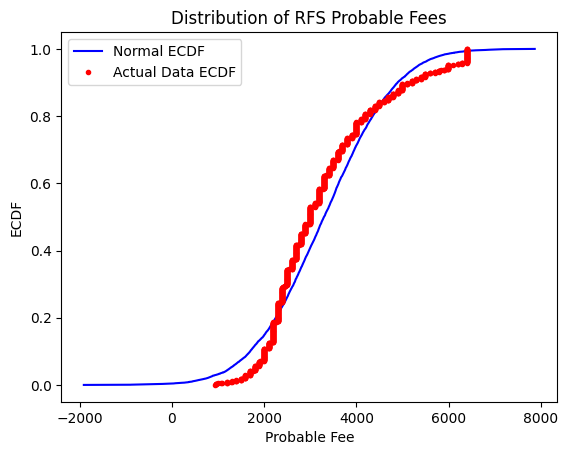

In [ ]:
#Normal Distribtuion
fee_probable = rfs_capped
std = np.std(fee_probable)
mean = np.mean(fee_probable)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

**Envelope**

In [ ]:
envelope = prop[prop['project_type']=='Envelope']

This one is still not fitting well

42997.823294216105


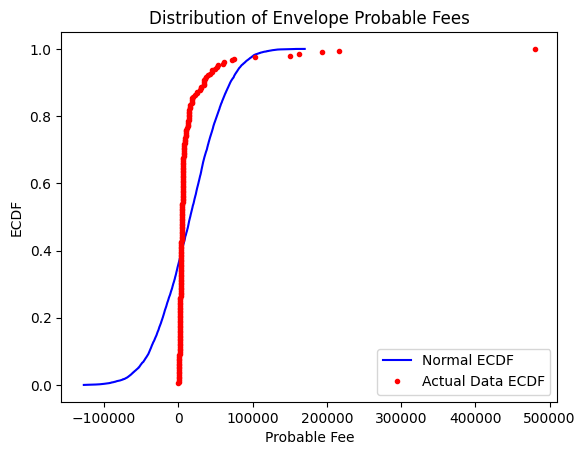

In [ ]:
#Normal Distribution
fee_probable = envelope['fee_probable']
mean = np.mean(fee_probable)
std = np.std(fee_probable)
print(std)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of Envelope Probable Fees')
plt.legend()
plt.show()

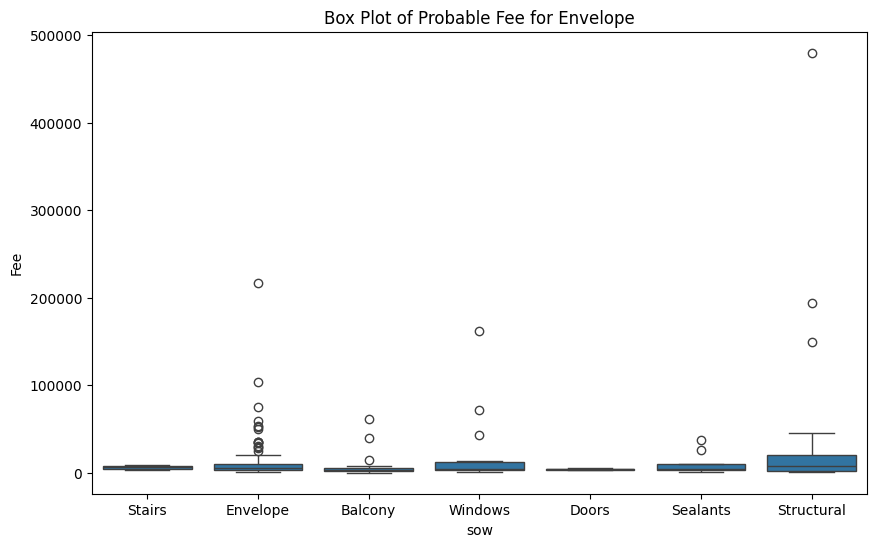

In [ ]:
#Boxplot of Envelope
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope")
plt.ylabel("Fee")

plt.show()

In [ ]:
envelope['sow'].value_counts()

,count
sow,
Envelope,101
Balcony,46
Structural,27
Windows,18
Sealants,8
Stairs,2
Doors,2


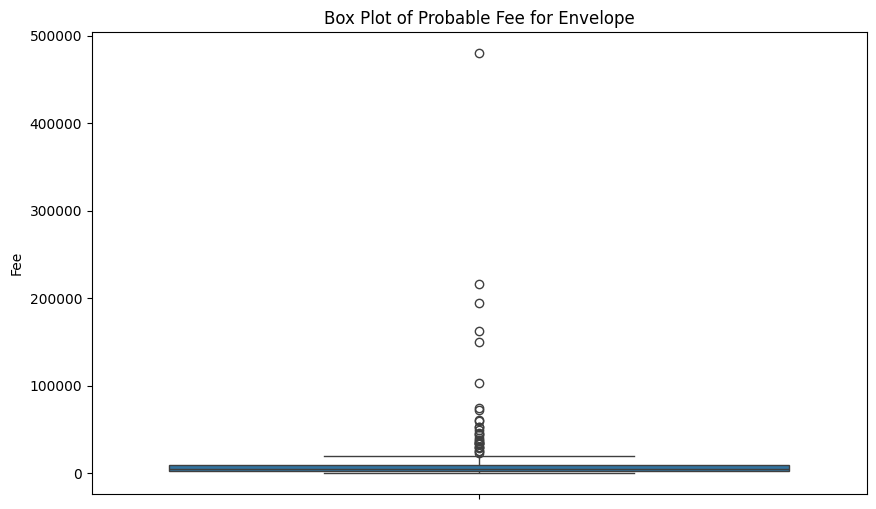

20850.0


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope")
plt.ylabel("Fee")

plt.show()

iqr = fee_probable.quantile(0.75) - fee_probable.quantile(0.25)
max_whisker = fee_probable.quantile(0.75) + 1.5 * iqr
print(max_whisker)

Outliers

There are quite a few outliers in this category. This isn't surprising given the very broad nature of the work done on these types of projects.

In [ ]:
print('total outliers: ', envelope[envelope['fee_probable'] > max_whisker].shape)
print('outliers %: ', envelope[envelope['fee_probable'] > max_whisker].shape[0] / envelope.shape[0])

total outliers:  (29, 24)
outliers %:  0.14215686274509803


We'll start with setting a category-wide cap

This doesn't do a good job of helping to explain the distribution. There is likely information that we're missing on these projects to help us appropriately categorize them (did the project only cover an assessment, or did it also include procurement to address the issues found in the assessment?)

In [ ]:
envelope_capped = envelope['fee_probable'].clip(upper=max_whisker)

6643.944553661044


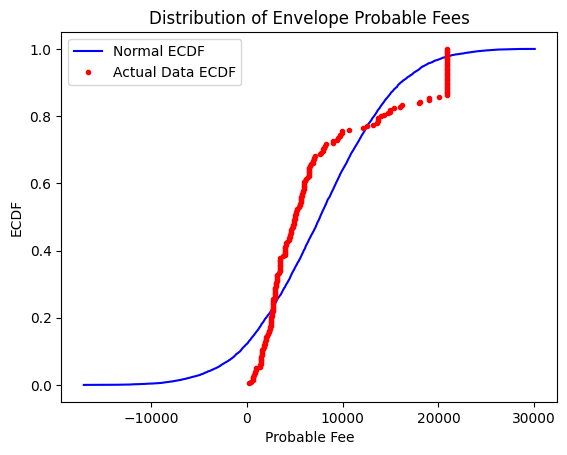

In [ ]:
#Normal Distribution
fee_probable = envelope_capped
mean = np.mean(fee_probable)
std = np.std(fee_probable)
print(std)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of Envelope Probable Fees')
plt.legend()
plt.show()

In conclusion, we're unable to explain the distribution for the fee_probable column with the information that we have. Therefore this column will likely not be a factor in our analysis

# **prev_rfs & reminder - keep**
Outcome varies significantly with these two RFS-specific columns

These columns are only applicable to RFS project types. Reserve Fund Studies have to be done every 3 years, so the team has included a flag for whether they did the building's previous rfs, and whether the proposal is being sent out as a reminder rather than having been asked for a quote

Since we found that project type is significant, we'll only work with rfs proposals in this section

In [ ]:
rfs = prop[prop['project_type']=='RFS']
rfs.head()

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region
0,Q191859,TS,Update RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q1,TOR
1,Q202049,PC,Class 2 RFS,0,39,2,NaN,-,No,No,...,0.000000,2.000000,0.000000,NaN,NaN,39.000000,49.000000,RFS,2019Q2,PC
2,Q201827,MT,Update RFS,0,46,5,-,-,Yes,Yes,...,0.000000,5.000000,0.000000,NaN,NaN,46.000000,NaN,RFS,2019Q2,TOR
3,Q200480,TC,Class 3 RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,Unknown
4,Q200559,TS,Class 2 RFS,0,320,17,-,4,Yes,No,...,0.000000,17.000000,0.000000,NaN,NaN,320.000000,49.000000,RFS,2019Q2,TOR


Cleaning up the columns

In [ ]:
pd.crosstab(rfs['prev_rfs'], rfs['reminder'], dropna=False)

reminder,No,Yes
prev_rfs,,
No,623,75
No,1,0
Yes,263,404
NaN,4,0


In [ ]:
rfs['prev_rfs'].unique()

array(['Yes', 'No', nan, 'No '], dtype=object)

In [ ]:
# Replace 'No ' with 'No'
rfs.loc[:, 'prev_rfs'] = rfs['prev_rfs'].replace('No ', 'No')
prop.loc[:, 'prev_rfs'] = prop['prev_rfs'].replace('No ', 'No')

# Fill NaN values with 'No'
rfs.loc[:, 'prev_rfs'] = rfs['prev_rfs'].fillna('No')
prop.loc[:, 'prev_rfs'] = prop['prev_rfs'].fillna('No')
print(rfs['prev_rfs'].unique())

['Yes' 'No']


There definitely seems to be an impact on outcome from these features. These two features will be brought through

In [ ]:
rfs.pivot_table(values = 'outcome', index = 'prev_rfs', columns = 'reminder', aggfunc=('mean', 'count'))

count          mean         
reminder    No  Yes       No      Yes
prev_rfs                             
No         628   75 0.353503 0.026667
Yes        263  404 0.722433 0.559406

# **prev_wins - discard**
This column is not significant as a # value or as a binary flag

This is a column that was created during data wrangling. It indicates how many previous projects have been completed for the client at the time that the proposal is issued.

In [ ]:
prop['prev_wins'].describe()

,prev_wins
count,3052.000000
mean,1.463630
std,6.672980
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,66.000000


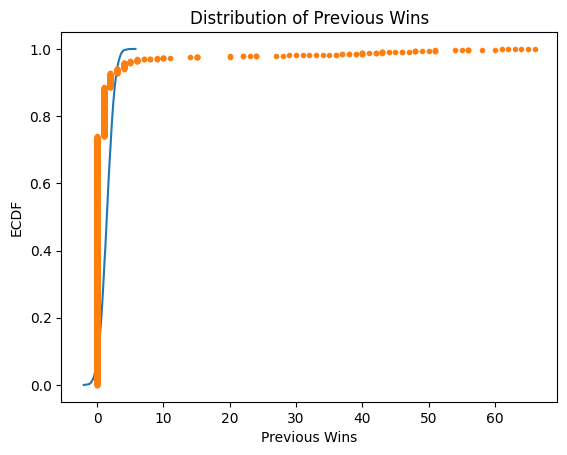

In [ ]:
#Distribution of prev_wins
mean = np.mean(prop['prev_wins'])
samples = rng.normal(mean, size=10000)
x, y  = ecdf(prop['prev_wins'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Previous Wins')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Previous Wins')
plt.show()

The values are almost all 0 (70+%) or 1 (15+%). Given this, it would be better to turn this variable into a flag for whether the client is a repeat client

In [ ]:
prop.loc[prop['prev_wins'] > 0, 'prev_wins'] = 1

In [ ]:
prop['prev_wins'].value_counts()

,count
prev_wins,
0.000000,2257
1.000000,795


Surprisingly little overlap between prev_wins and prev_rfs. The prev_rfs column should be considered more accurate since it is checked and entered manaually for each proposal. The prev_wins column ay be off due to it only being based on what is in this file, which starts in 2019. Given this, we will disregard the prev_wins columns

In [ ]:
pd.crosstab(prop['prev_rfs'], prop['prev_wins'], dropna=False)

prev_wins,0.000000,1.000000
prev_rfs,,
-,2,1
No,1820,546
Yes,435,248


# **townhouse_flag - discard**
This information is also included in the building_type column which we will be using instead

This flag indicates whether the building the proposal relates to is a townhouse

The townhouse flag is generally only available for RFS proposals

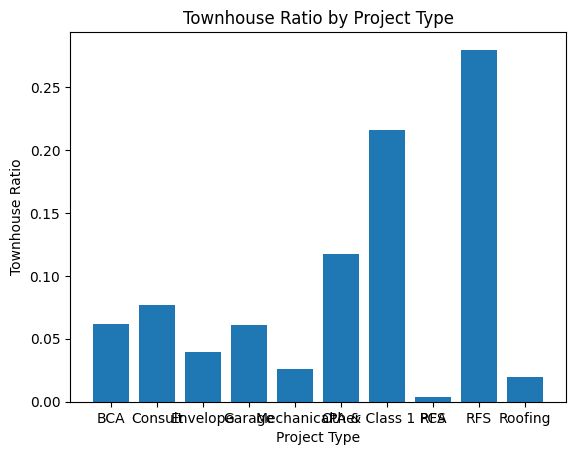

In [ ]:
townhouse_ratio = prop.groupby('project_type')['townhouse_flag'].mean()

#create a chart that displays the townhouse_ratio
fig, ax = plt.subplots()
ax.bar(townhouse_ratio.index, townhouse_ratio.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Townhouse Ratio')
ax.set_title('Townhouse Ratio by Project Type')
plt.show()

At first glance, even within the RFS project type, the townhouse flag seems to have little impact

In [ ]:
rfs.groupby('townhouse_flag')['outcome'].mean()

,outcome
townhouse_flag,
0.000000,0.466059
1.000000,0.469974


In [ ]:
#convert the flag from float to int
rfs['townhouse_flag'] = rfs['townhouse_flag'].astype(int)
prop['townhouse_flag'] = prop['townhouse_flag'].astype(int)

<ipython-input-138-8cb652061732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs['townhouse_flag'] = rfs['townhouse_flag'].astype(int)


Hypothesis: townhouse_flag has no impact on outcome for RFS projects

In [ ]:
sample_a = rfs[rfs['townhouse_flag'] == 1]['outcome']
sample_b = rfs[rfs['townhouse_flag'] == 0]['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.4769


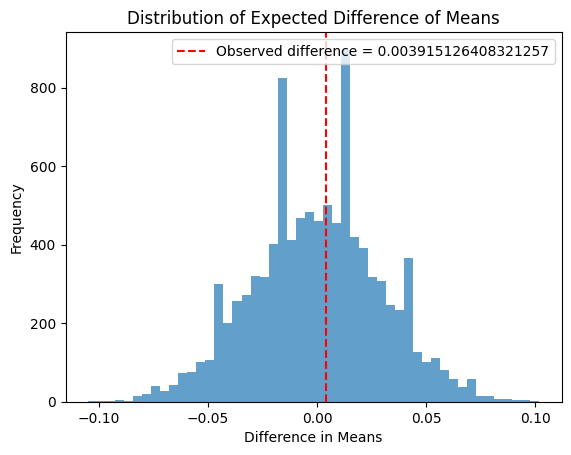

In [ ]:
import matplotlib.pyplot as plt
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

The townhouse_flag doesn't seem to make a significant difference to the win ratio even within the RFS project type. The p-value is moderately low at 0.46, so there is little chance that there is something here. The team lead said they are well known for their townhouse work, so I'm going to leave this feature in for the sake of further exploration.

# **storeys - discard**
This column is highly skewed and would not be usable. There is also collinearity with units

This column indicates how many storeys are in the building that the proposal relates to.

Basic exploration

There are a lot of missing values in this column (1361 nulls vs 930 non-null).

In [ ]:
print(prop['storeys'].describe())

print('# of nulls: ', prop['storeys'].isnull().sum())

count   1089.000000
mean      10.712580
std       23.058929
min        1.000000
25%        3.000000
50%        4.000000
75%       14.000000
max      637.000000
Name: storeys, dtype: float64
# of nulls:  1963


RFS is the only project_type where the storeys column seems to be used. It is still null for over 40% of the RFS proposals though. Need to explore whether there is a pattern to when it is used. Building types like townhouses may not have storeys

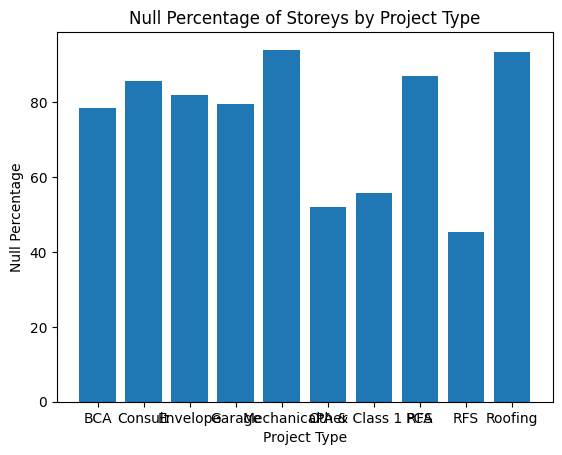

In [ ]:
#chart of % of nulls in storey by project_type
null_percentage = prop.groupby('project_type')['storeys'].apply(lambda x: x.isnull().mean()) * 100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.title('Null Percentage of Storeys by Project Type')
plt.show()

Buildings that are townhouses and POTLS usually do not have data on storeys. This makes sense since these buildings are almost never high-rises. Commercial buildings do often have storey information though

In [ ]:
print(rfs.groupby('townhouse_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)
print(rfs.groupby('comm_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)

rfs['potl_flag'] = rfs['potl_units'].apply(lambda x: 1 if x > 0 else 0)

print(rfs.groupby('potl_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)

townhouse_flag
0   34.853090
1   71.801567
Name: storeys, dtype: float64
comm_flag
0.000000   47.753744
1.000000   26.785714
Name: storeys, dtype: float64
potl_flag
0    41.601866
1   100.000000
Name: storeys, dtype: float64


<ipython-input-143-eeaa47146a15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs['potl_flag'] = rfs['potl_units'].apply(lambda x: 1 if x > 0 else 0)


Townhouses & POTLS are usually regular residences, so we can likely interpolate the storeys for these

Townhouses are prodominently 2 storeys, which makes sense. We'll apply this as the storeys value for all null townhouses

In [ ]:
rfs[rfs['townhouse_flag'] == 1]['storeys'].describe()

,storeys
count,108.000000
mean,4.101852
std,7.107900
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,57.000000


There is no storey information to look at for POTLS, but these are usually detached residential homes, so we will assume these are 2 storeys as well

In [ ]:
rfs.loc[(rfs['potl_flag'] == 1) & (rfs['storeys'].isnull()), 'storeys'] = 2

**Outliers**

There are some very clear outliers. The tallest skyscraper in Ontario is 78 storeys (excluding the CN tower), so these must be errors

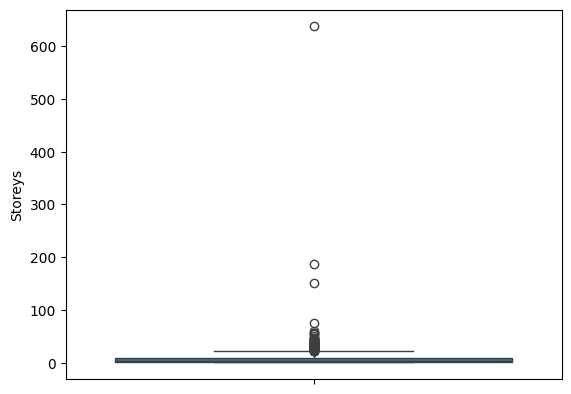

In [ ]:
#boxplot of storeys from rfs_storeys
_ = sns.boxplot(y='storeys', data = rfs)
_ = plt.ylabel('Storeys')

In [ ]:
#set any storeys values that are over 78 to null
rfs.loc[rfs['storeys'] > 78, 'storeys'] = np.nan
prop.loc[prop['storeys'] > 78, 'storeys'] = np.nan

There are still quite a few nulls in storeys. This feature may not be useable since we can't reasonably try to predict the value to fill in the NaNs

In [ ]:
#nulls in storeys
print('nulls: ', rfs['storeys'].isnull().sum())
print('not null: ', rfs['storeys'].notnull().sum())

nulls:  538
not null:  832


**Distribution**

Storeys can be described only after nulls, townhouses and potls are removed. This is a small subset so the feature may not be useable

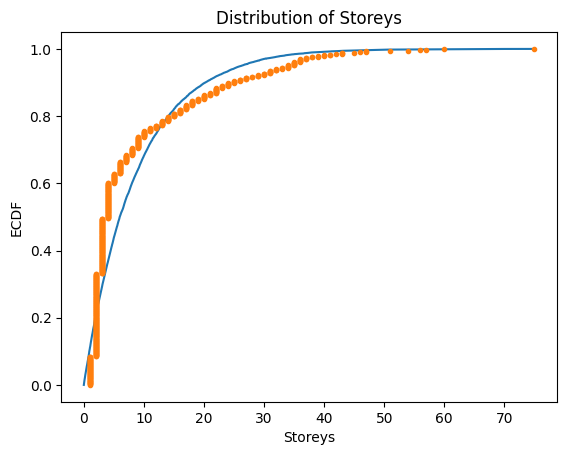

In [ ]:
#Exponential Distribution
rfs_nona = rfs.dropna(subset=['storeys'])

rng = np.random.default_rng()

mean = np.mean(rfs_nona['storeys'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs_nona['storeys'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Storeys')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Storeys')
plt.show()

It looks like all of the 2 storeys for townhouses and potls are creating a large cluster. Lets remove those and see what it looks like

In [ ]:
#remove records where townhouse_flag or potl_flag = 1
rfs_storeys = rfs[~((rfs['townhouse_flag'] == 1) | (rfs['potl_flag'] == 1))]

The distribution is very close to exponential when nulls, townhouses and potls are removed.

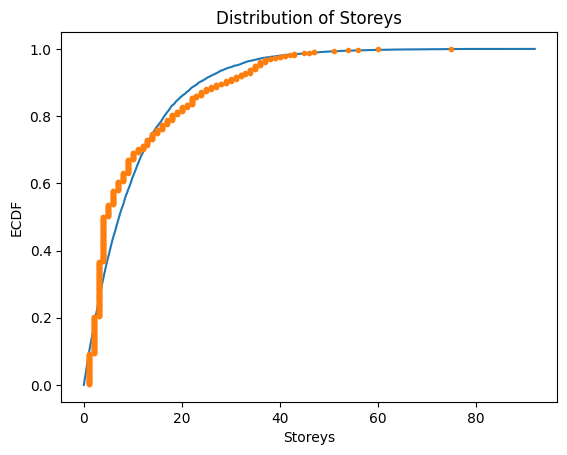

In [ ]:
#Exponential
rfs_storeys_nona = rfs_storeys.dropna(subset=['storeys'])

rng = np.random.default_rng()

mean = np.mean(rfs_storeys_nona['storeys'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs_storeys_nona['storeys'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Storeys')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Storeys')
plt.show()

In [ ]:
print('Of the rfs projects that are not Townhouses or POTLS:')
print('nulls: ', rfs_storeys['storeys'].isnull().sum())
print('not null: ', rfs_storeys['storeys'].notnull().sum())

Of the rfs projects that are not Townhouses or POTLS:
nulls:  264
not null:  640


**Collinearity**

The storeys column is likely correlated with the region. Would expect to see higher stories in the TOR region

The TOR region does have most of the larger storied buildings.

In [ ]:
rfs_storeys.groupby('region')['storeys'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
EO,71.000000,5.563380,6.079785,1.000000,3.000000,3.000000,5.000000,29.000000
GH,25.000000,4.760000,2.332381,1.000000,4.000000,4.000000,6.000000,12.000000
GR,5.000000,3.400000,1.949359,2.000000,2.000000,2.000000,5.000000,6.000000
HUR,59.000000,3.338983,1.987983,1.000000,2.000000,3.000000,4.000000,15.000000
LON,4.000000,5.000000,1.154701,4.000000,4.000000,5.000000,6.000000,6.000000
PC,53.000000,13.773585,13.741629,1.000000,2.000000,8.000000,22.000000,56.000000
TOR,312.000000,15.076923,12.983560,1.000000,4.000000,10.000000,22.000000,75.000000
Unknown,30.000000,3.900000,3.241434,1.000000,1.000000,4.000000,4.000000,13.000000
WIN,2.000000,14.000000,0.000000,14.000000,14.000000,14.000000,14.000000,14.000000


Given the relation with region which we know will be an important feature, the large number of nulls, and the limited applicability of this column, we'll won't be bringing it forward into the analysis

# **building_type - keep**
There is significant differences in outcome between the different building types. This is available only for RFS proposals

The columns potl_flag, townhouse_flag, comm_flag all relate to different building types. We may want to combine these into one categorical feature

In [ ]:
#start with assigning potl and townhouse since they are easy 1 to 1
prop['building_type'] = prop['potl_units'].apply(lambda x: 'potl' if x > 0 else 'unknown')
prop.loc[prop['townhouse_flag'] == 1, 'building_type'] = 'townhouse'

In [ ]:
#comm_flag can sometimes be applied to mixed use buildings, so we need to look for residential and comm units
prop.loc[(prop['comm_flag'] == 1) & (prop['res_units'] > 0), 'building_type'] = 'mixed_use'
prop.loc[(prop['comm_flag'] == 1) & (prop['building_type'] == 'unknown'), 'building_type'] = 'commercial'

In [ ]:
#set any remaining that have storeys > 3 to highrise
prop.loc[(prop['storeys'] > 3) & (prop['building_type'] == 'unknown'), 'building_type'] = 'highrise'

In [ ]:
#Set any 'none' with res_units > 0 and storeys > 0 to 'residential'
prop.loc[(prop['res_units'] > 0) & (prop['building_type'] == 'unknown') & (prop['storeys'] > 0), 'building_type'] = 'residential'

In [ ]:
prop['building_type'].value_counts(dropna=False)

,count
building_type,
unknown,1498
highrise,567
townhouse,482
residential,181
commercial,172
potl,113
mixed_use,39


There are a lot of entries we haven't been able to classify. Lets break it down

As expected there are a lot less nulls within the RFS project_type, but still enough for it to be an issue

project_type
BCA                79.037801
Consult            78.947368
Envelope           77.941176
Garage             74.489796
Mechanical         93.103448
Other              48.044693
PA & Class 1 RFS    6.818182
PCA                91.044776
RFS                16.642336
Roofing            90.849673
Name: building_type, dtype: float64


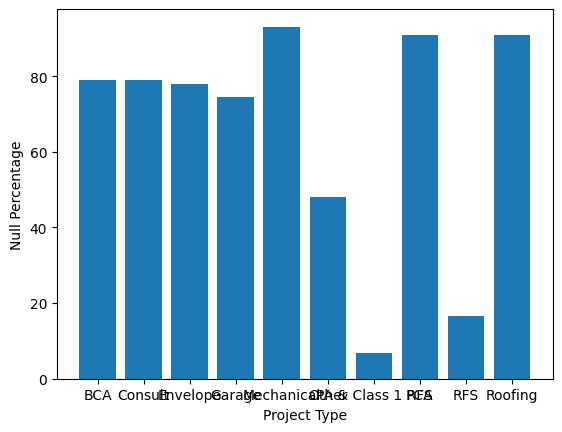

In [ ]:
#% of 'none' by project_type
none_percentage = prop.groupby('project_type')['building_type'].apply(lambda x: (x == 'unknown').mean()) * 100

fig, ax = plt.subplots()
ax.bar(none_percentage.index, none_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt

print(none_percentage)

Taking a look at RFS rows that aren't being captured, there are a lot classified as industrial. We'll add these to the commercial classification

In [ ]:
#view 10 rows where building_type is none and project_type is rfs
pd.set_option('display.max_colwidth', None)
prop[(prop['building_type'] == 'unknown') & (prop['project_type'] == 'RFS')].head(20)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type
0,Q191859,TS,Update RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q1,TOR,unknown
3,Q200480,TC,Class 3 RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,Unknown,unknown
5,Q200554,SC,Class 3 RFS,0,48,NaN,NaN,1,Yes,No,...,NaN,0.000000,NaN,NaN,48.000000,49.000000,RFS,2019Q2,HUR,unknown
6,Q200558,TS,Class 1 RFS,0,NaN,NaN,NaN,2,No,No,...,NaN,0.000000,NaN,NaN,NaN,49.000000,RFS,2019Q2,TOR,unknown
10,Q200345,MT,Class 2 RFS,0,-,-,-,-,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,18.000000,RFS,2019Q2,TOR,unknown
11,Q200587,Ru,Class 2 RFS,0,3docks,-,-,-,No,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,Unknown,unknown
12,Q200514,YR,Class 2 RFS,0,189,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,189.000000,49.000000,RFS,2019Q2,YR,unknown
13,Q200531,YR,Class 2 RFS,0,93,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,93.000000,49.000000,RFS,2019Q2,YR,unknown
14,Q200518,YR,Class 2 RFS,0,158,NaN,-,3?,Yes,No,...,NaN,0.000000,NaN,NaN,158.000000,49.000000,RFS,2019Q2,YR,unknown
15,Q200525,YR,Class 2 RFS,0,440,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,440.000000,NaN,RFS,2019Q2,YR,unknown


In [ ]:
prop['building_type'].value_counts(dropna=False)

,count
building_type,
unknown,1498
highrise,567
townhouse,482
residential,181
commercial,172
potl,113
mixed_use,39


There seems to be gaps in the building_type classification. where the storeys column is null. Lets see if we can use unit_count to classify in these cases

In [ ]:
#create a combined units column that adds the three other unit columns together
prop['units'] = (prop['res_units'].fillna(0) +
                 prop['comm_units'].fillna(0) +
                 prop['potl_units'].fillna(0))

#set any 0s in the units column to nulls
prop.loc[prop['units'] == 0, 'units'] = np.nan

# Check the summary statistics
print(prop['units'].describe())

count   1642.000000
mean     110.209501
std      142.733252
min        1.000000
25%       24.000000
50%       51.000000
75%      139.000000
max     1343.000000
Name: units, dtype: float64


In [ ]:
#Units for null storeys and Unknown building_type
prop[prop['storeys'].isnull() & (prop['building_type'] == 'unknown')]['units'].describe()

,units
count,181.000000
mean,143.016575
std,218.520085
min,1.000000
25%,27.000000
50%,55.000000
75%,158.000000
max,1343.000000


In [ ]:
#Units for highrise building type
prop[prop['building_type'] == 'highrise']['units'].describe()

,units
count,530.000000
mean,187.513208
std,151.837083
min,3.000000
25%,67.000000
50%,146.000000
75%,283.750000
max,1012.000000


In [ ]:
#Units for townhouse building type
prop[prop['building_type'] == 'townhouse']['units'].describe()

,units
count,444.000000
mean,62.603604
std,71.015533
min,3.000000
25%,24.000000
50%,40.000000
75%,79.000000
max,810.000000


In [ ]:
#Units for potl building types
prop[prop['building_type'] == 'potl']['units'].describe()

,units
count,113.000000
mean,50.530973
std,43.017661
min,2.000000
25%,21.000000
50%,40.000000
75%,66.000000
max,224.000000


In [ ]:
#Units for commercial building types
prop[prop['building_type'] == 'commercial']['units'].describe()

,units
count,154.000000
mean,34.051948
std,52.608406
min,1.000000
25%,12.000000
50%,20.500000
75%,38.750000
max,500.000000


There's almost no overlap in unit count between highrises and the other building types which makes sense. We will assume anything with a unit count above 68 is a highrise (25th percentile for highrise)

In [ ]:
prop.loc[(prop['building_type'] == 'unknown') & (prop['units'] > 75), 'building_type'] = 'highrise'

In [ ]:
prop[prop['project_type'] == 'RFS']['building_type'].value_counts(dropna=False)

,count
building_type,
highrise,413
townhouse,381
unknown,180
residential,146
commercial,139
potl,83
mixed_use,28


project_type
BCA                79.037801
Consult            75.789474
Envelope           76.960784
Garage             72.448980
Mechanical         91.379310
Other              41.899441
PA & Class 1 RFS    5.681818
PCA                91.044776
RFS                13.138686
Roofing            90.196078
Name: building_type, dtype: float64


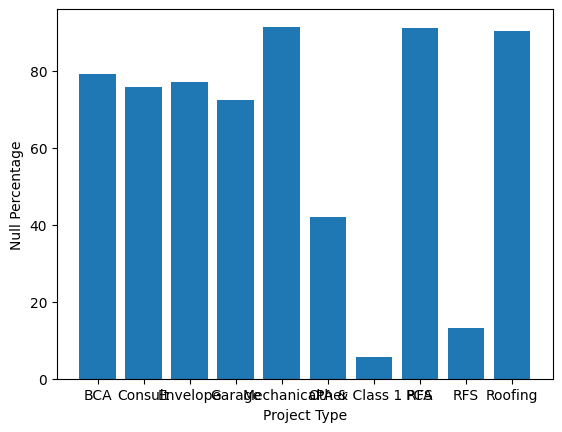

In [ ]:
#% of 'none' by project_type
none_percentage = prop.groupby('project_type')['building_type'].apply(lambda x: (x == 'unknown').mean()) * 100

fig, ax = plt.subplots()
ax.bar(none_percentage.index, none_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt

print(none_percentage)

With 13% nulls for the building_type flag within the RFS project_type, the feature is usable.

**Impact**

Does the building_type column impact outcome for RFS projects?

In [ ]:
rfs = prop[prop['project_type'] == 'RFS']

In [ ]:
rfs['building_type'].value_counts()

,count
building_type,
highrise,413
townhouse,381
unknown,180
residential,146
commercial,139
potl,83
mixed_use,28


At a high-level there does seem to be an impact

In [ ]:
rfs.groupby('building_type')['outcome'].mean()

,outcome
building_type,
commercial,0.582734
highrise,0.426150
mixed_use,0.321429
potl,0.554217
residential,0.527397
townhouse,0.467192
unknown,0.405556


Commercial and Highrise building_types have a large difference in mean outcome, so lets test these ones

There is definitely seems to be something here! We'll keep this column for further exploration

In [ ]:
sample_a = rfs[rfs['building_type'] == 'commercial']['outcome']
sample_b = rfs[rfs['building_type'] == 'highrise']['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0005


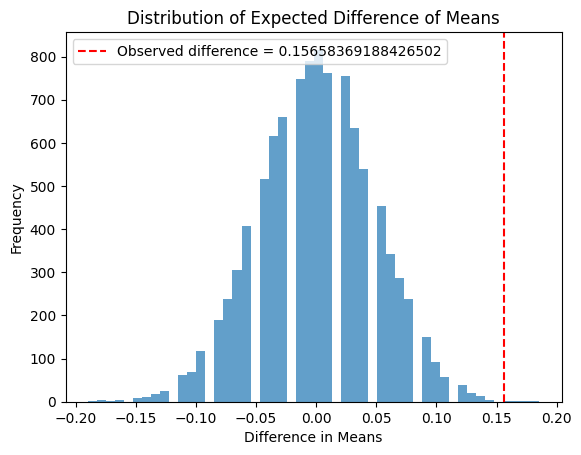

In [ ]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

# **units - keep**
There appears to be significant differences in outcomes by unit counts. This feature is highly skewed and will have to be bucketed to be used

This is the number of units in a building or collection of buildings that the proposal pertains to.

**Nulls**

There is a fairly high number of nulls in this column

In [ ]:
print('nulls: ', prop['units'].isnull().sum())
print('not null: ', prop['units'].notnull().sum())

nulls:  1410
not null:  1642


Once again it looks like this column is only dependable for the RFS project type

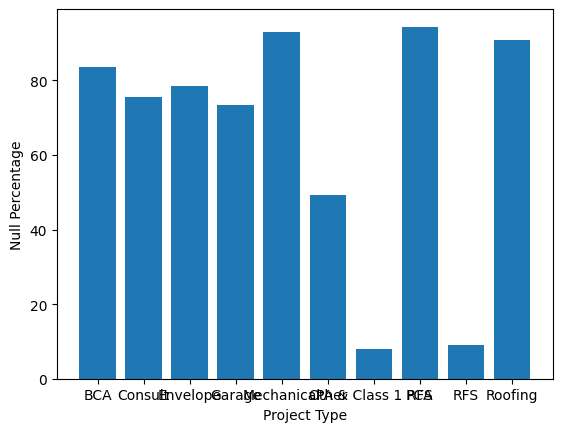

project_type
BCA                83.505155
Consult            75.438596
Envelope           78.431373
Garage             73.469388
Mechanical         93.103448
Other              49.162011
PA & Class 1 RFS    7.954545
PCA                94.402985
RFS                 9.124088
Roofing            90.849673
Name: units, dtype: float64


In [ ]:
#% of nulls by project_type
null_percentage = prop.groupby('project_type')['units'].apply(lambda x: x.isnull().mean()) *100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.show()

print(null_percentage)

In [ ]:
rfs = prop[prop['project_type'] == 'RFS']

#set any 0s in the units column to nulls
rfs.loc[rfs['units'] == 0, 'units'] = np.nan
prop.loc[prop['units'] == 0, 'units'] = np.nan

The nulls within RFS seem to be mostly found in building types that are unknown. There is a small number of nulls so this column is useable

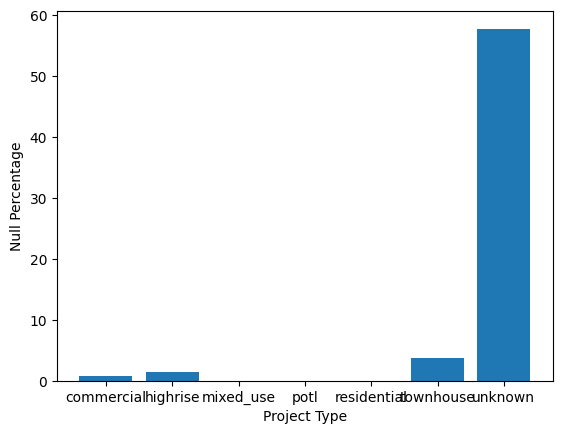

building_type
commercial     0.719424
highrise       1.452785
mixed_use      0.000000
potl           0.000000
residential    0.000000
townhouse      3.674541
unknown       57.777778
Name: units, dtype: float64


In [ ]:
#% nulls in units by building_type
null_percentage = rfs.groupby('building_type')['units'].apply(lambda x: x.isnull().mean()) *100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.show()

print(null_percentage)

**Distribution**

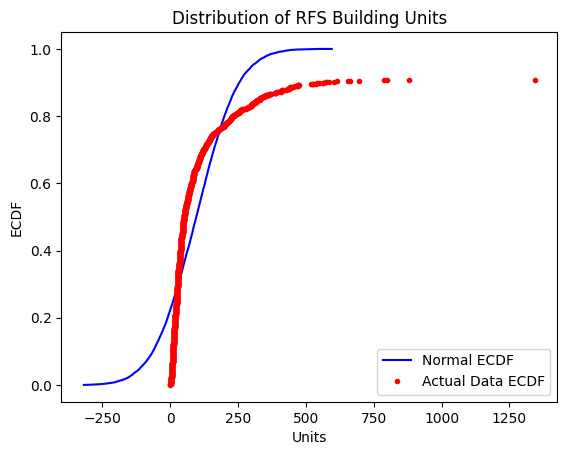

In [ ]:
#Normal Distribution
units = rfs['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Building Units')
plt.legend()
plt.show()

Lets try breaking this up by building_type

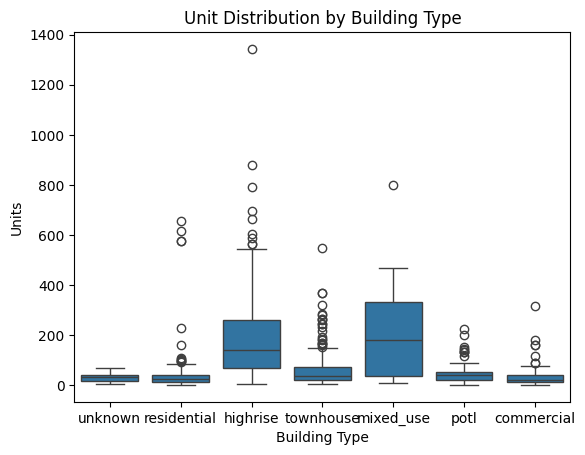

In [ ]:
#boxplot of units by building_type
_ = sns.boxplot(x='building_type', y='units', data = rfs)
_ = plt.ylabel('Units')
_ = plt.xlabel('Building Type')
_ = plt.title('Unit Distribution by Building Type')
plt.show()

The residential bucket seems a bit odd - should these outliers be classified as highrise?

Most of these high-unit residential buildings look to be highrises that had an original storeys value that was too complex to parse correctly. The storeys column is what we used to define highrise

In [ ]:
rfs[(rfs['building_type'] == 'residential') & (rfs['units'] > 200)].head(20)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type,units
123,Q201221,PC,Update RFS,0,616,2,-,-,Yes,No,...,0.000000,NaN,NaN,616.000000,10.000000,RFS,2019Q3,PC,residential,616.000000
551,Q212057,PC,Class 2 RFS,0,228,2,-,-,No,No,...,0.000000,NaN,NaN,228.000000,41.000000,RFS,2020Q4,PC,residential,228.000000
801,Q220913,TS,Update RFS,0,575,27\n23\nconnectected by 3-storey podium,-,2,Yes,No,...,0.000000,NaN,NaN,575.000000,4.000000,RFS,2021Q2,TOR,residential,575.000000
1709,PCC-231821-00,TS,Class 2 RFS,0,657,1,-,4,No,No,...,0.000000,NaN,NaN,657.000000,18.000000,RFS,2022Q3,TOR,residential,657.000000
3000,PCC-252059-00,TS,Class 2 RFS,0,575,27\n23\nconnectected by 3-storey podium,-,2,Yes,No,...,0.000000,NaN,NaN,575.000000,7.000000,RFS,2024Q2,TOR,residential,575.000000


Highrise

This distribution is better but still not a fit

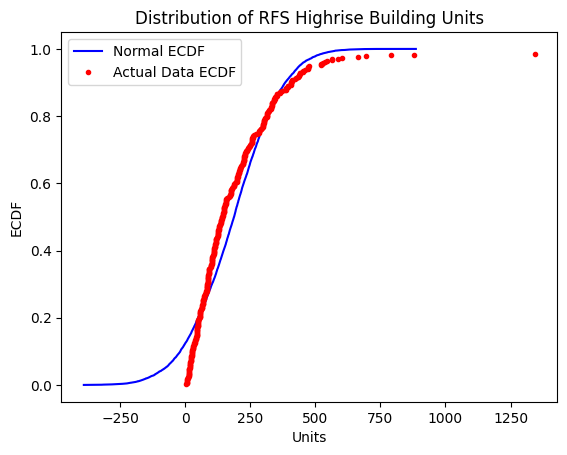

In [ ]:
#Normal Distribution
units = rfs[rfs['building_type'] == 'highrise']['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Highrise Building Units')
plt.legend()
plt.show()

Definitely not normally distributed

In [ ]:
units_clean = rfs[rfs['building_type'] == 'highrise']['units'].dropna()
stat, p_value = shapiro(units_clean)
print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p_value:.4f}")

Shapiro-Wilk Test Statistic: 0.8542967782149701, P-value: 0.0000


Townhouse

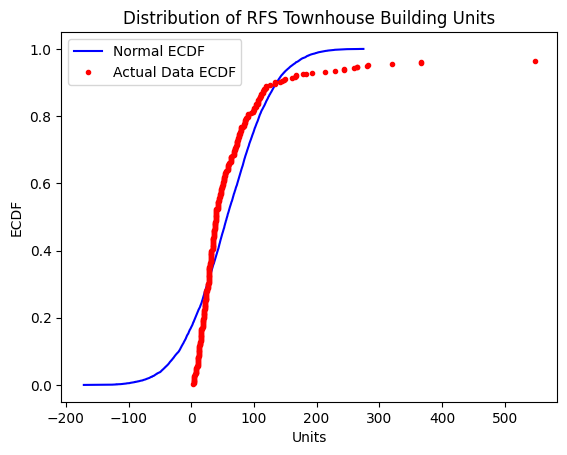

In [ ]:
#Normal Distribution
units = rfs[rfs['building_type'] == 'townhouse']['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Townhouse Building Units')
plt.legend()
plt.show()

Some of these values are suspiciously high but they actually look legitimate

In [ ]:
rfs[(rfs['building_type'] == 'townhouse') & (rfs['units'] > 200)].head(10)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type,units
64,Q200794,OC,Class 2 RFS,0,214,2,2,-,No,No,...,0.000000,NaN,NaN,214.000000,40.000000,RFS,2019Q3,EO,townhouse,214.000000
245,Q202007,PC,Update RFS,0,280,23,2,2,Yes,Yes,...,0.000000,NaN,NaN,280.000000,50.000000,RFS,2020Q1,PC,townhouse,280.000000
438,Q210557,YC,Class 2 RFS,0,548,2,47,-,No,Yes,...,0.000000,NaN,NaN,548.000000,44.000000,RFS,2020Q3,TOR,townhouse,548.000000
495,Q211514,HC,Update RFS,0,264,4,10,1,Yes,No,...,0.000000,NaN,NaN,264.000000,3.000000,RFS,2020Q3,GH,townhouse,264.000000
521,Q211727,YC,Class 2 RFS,0,243,9 + TH,8,1,Yes,Yes,...,0.000000,NaN,NaN,243.000000,43.000000,RFS,2020Q3,TOR,townhouse,243.000000
545,Q212020,TS,Update RFS,0,260,2 x 12,1,3,Yes,Yes,...,0.000000,NaN,NaN,260.000000,17.000000,RFS,2020Q4,TOR,townhouse,260.000000
942,PCC-222276-00,PC,Class 2 RFS,0,230,-,16,-,Yes,Yes,...,0.000000,NaN,NaN,230.000000,29.000000,RFS,2021Q3,PC,townhouse,230.000000
2016,PCC-233723-00,PC,Class 2 RFS,0,367,31,1 block,2 upper SF\n2 lower SF,No,No,...,0.000000,NaN,NaN,367.000000,17.000000,RFS,2023Q1,PC,townhouse,367.000000
2017,PCC-233724-00,PC,Class 2 RFS,0,367,31,1 block,2 upper SF\n2 lower SF,No,No,...,0.000000,NaN,NaN,367.000000,17.000000,RFS,2023Q1,PC,townhouse,367.000000
2424,PCC-241777-00,HC,Update RFS,0,264,-,10,1,Yes,No,...,0.000000,NaN,NaN,264.000000,6.000000,RFS,2023Q3,GH,townhouse,264.000000


I'm not able to describe the units distribution well. I suspect it is important though since it my only indicator of building size

**Bucketing**

Highrise

We'll start by creating very basic bins

In [ ]:
#create 10 bins for the building_type = highrise units
rfs.loc[rfs['building_type'] == 'highrise', 'units_bin'] = pd.cut(
    rfs[rfs['building_type'] == 'highrise']['units'], bins=10
)

<ipython-input-187-c380683dfda5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs.loc[rfs['building_type'] == 'highrise', 'units_bin'] = pd.cut(


In [ ]:
rfs[rfs['building_type']=='highrise'].groupby('units_bin')['outcome'].agg(['count', 'mean'])

<ipython-input-188-ea3eb138008c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfs[rfs['building_type']=='highrise'].groupby('units_bin')['outcome'].agg(['count', 'mean'])


,count,mean
units_bin,,
"(1.66, 137.0]",198,0.500000
"(137.0, 271.0]",110,0.345455
"(271.0, 405.0]",60,0.400000
"(405.0, 539.0]",29,0.344828
"(539.0, 673.0]",6,0.333333
"(673.0, 807.0]",2,0.000000
"(807.0, 941.0]",1,0.000000
"(941.0, 1075.0]",0,NaN
"(1075.0, 1209.0]",0,NaN


Based on this there could be fluctuations in outcome related to unit count. We'll bring this freature through to explore how to better use it

# **issued_date - discard**
Variation in outcome over time looks to be tied to changes in project type composition. We will drop this column

This is the date that the proposal was sent out to the client

**Nulls**

In [ ]:
print('nulls: ', prop['issued_date'].isnull().sum())
print('not null: ', prop['issued_date'].notnull().sum())

nulls:  0
not null:  3052


There are very few nulls. If this is null, we will assume it was not sent out. We will remove any row with a null

In [ ]:
#drop rows where issued_date is null
prop.dropna(subset=['issued_date'], inplace=True)

**Impact**

In [ ]:
#create quarter column
prop['quarter'] = prop['issued_date'].dt.to_period('Q')

The overall win rate has generally increased over time. At the begining of 2022 we saw the win rate go up.

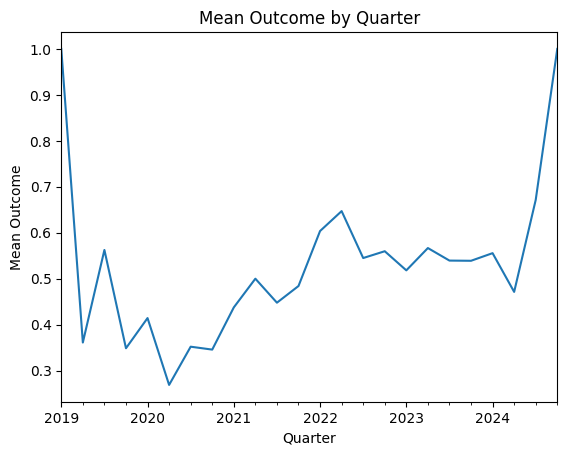

In [ ]:
#mean outcome over time
prop.groupby('quarter')['outcome'].mean().plot(kind='line')
plt.xlabel('Quarter')
plt.ylabel('Mean Outcome')
plt.title('Mean Outcome by Quarter')
plt.show()

Did proposal composition change around this time?

The trend in increasing project_type variety lines up very closely with the increase in outcome!

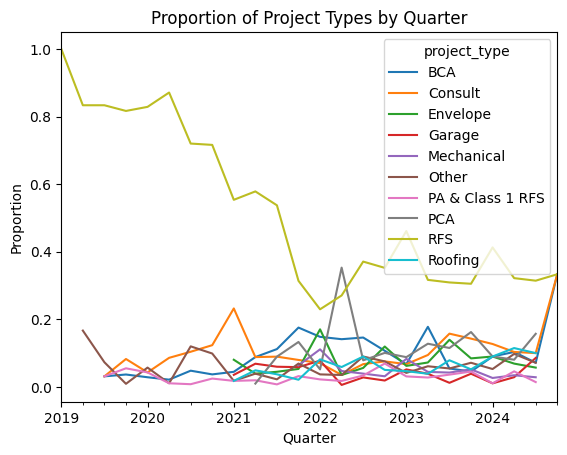

In [ ]:
#% proposals by project_type for each quarter
prop.groupby('quarter')['project_type'].value_counts(normalize=True).unstack().plot(kind='line')
plt.xlabel('Quarter')
plt.ylabel('Proportion')
plt.title('Proportion of Project Types by Quarter')
plt.show()

Since the variation in outcome over time is mostly explainable by project_type, we don't need to keep the issued_date column

# **building_age - discard**
Non-normal distribution with the outcome remaining relatively stable across age groups

This column indicates the age of the building that the proposal relates to at the issued_date

The distribution is definitely not normal. We will leave this feature out of our analysis

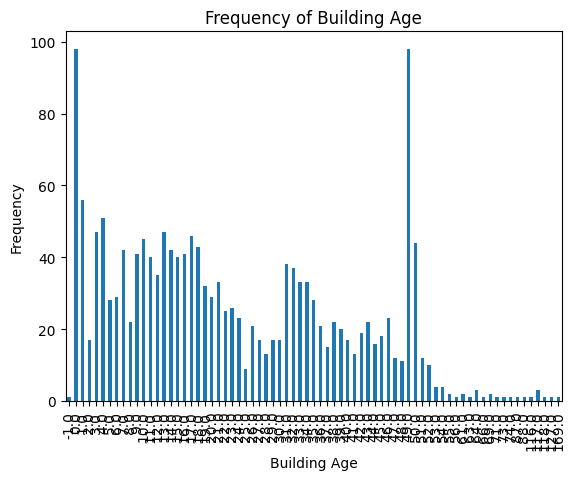

In [ ]:
age_counts = prop['building_age'].value_counts().sort_index()

age_counts.plot(kind='bar')

plt.xlabel('Building Age')
plt.ylabel('Frequency')
plt.title('Frequency of Building Age')

plt.show()

<ipython-input-195-45e47ee4682d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop.groupby(pd.cut(prop['building_age'], bins=15))['outcome'].mean().plot(kind='bar')


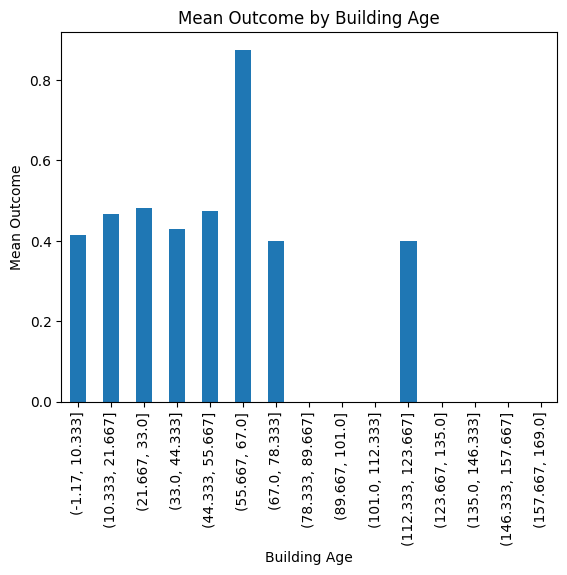

In [ ]:
prop.groupby(pd.cut(prop['building_age'], bins=15))['outcome'].mean().plot(kind='bar')
plt.xlabel('Building Age')
plt.ylabel('Mean Outcome')
plt.title('Mean Outcome by Building Age')
plt.show()

# **Collinearity**

The list of features we have selected are:

*   outcome
*   region (categorical)
*   project_type (categorical)
*   prev_rfs (binary)
*   reminder (binary)
*   building_type (categorical)
*   units (continuous but may need bucketing)
*   probable_fee (continuous but not desccribable - will need to be bucketed)











Since these are mostly categorical features we will need to wait until we have converted them to dummie variables before we assess collinearity.

# **Final Export**

In [ ]:
from google.colab import files
prop.to_csv('2.1 EDA Output.csv')
files.download("2.1 EDA Output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

from google.colab import files
prop.to_csv('1.2 DW Output.csv')
files.download("1.2 DW Output.csv")